In [2]:
# when importing the new dataset, compare this one with median prices to the zillow estimate 

In [63]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm 

from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

import pickle

import warnings

warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

# Methods <a id='methods'></a>

[Test](#test)



# Define Methods

In [79]:
"""
Check a series for stationarity
Use Augmented Dickey-Fuller unit root test 
visualize rolling mean and standard deviation 
"""
def stationarity_check(df):
    
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12,center=False).std()
    
    dftest = adfuller(df)
    
    fig = plt.figure(figsize=(12,6))
    plt.plot(df, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean and std')
    plt.show(block=False)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#lags used', 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)

"""
Grid search for best pdq value based on aic 
return two tuples containing optimal pdq and pdqs values for fitting in SARIMAX model 
"""
def get_pdqs(df, seasonal=12, display=True):   

    # p d and q can be 0, 1 or 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p (autogressive terms), d (differencing), and q (moving average terms)
    pdq = list(itertools.product(p, d, q))
    
    # do the same with seasonal 
    # default 12: this data has a yearly seasonal component  
    pdqs = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

    # Takes the permutations above and runs a grid search to find the model with the lowest AIC score 
    output = []
    for combo in pdq:
        for combo_seasonal in pdqs:
            try:
                results = train_sarimax(df, pdq=combo, PDQS=combo_seasonal, summary=False)
                
                output.append([combo, combo_seasonal, results.aic]) 
            
                if display:
                    print(f'pdq: {combo}; pdqs: {combo_seasonal}, AIC: {results.aic}')
            except:
                continue
            
    # Find the parameters with minimal AIC value
    output_df = pd.DataFrame(output, columns=['pdq', 'pdqs', 'aic']) 

    pdq = tuple(output_df[output_df.aic == output_df.aic.min()]['pdq'].values[0])
    PDQS = tuple(output_df[output_df.aic == output_df.aic.min()]['pdqs'].values[0])

    return output_df, pdq, PDQS 

"""
Grid search for best pdq value based on aic 
return two tuples containing optimal pdq and pdqs values for fitting in SARIMAX model 
"""
def get_pdqs_cv(df, train, seasonal=12, optimize='aic', display=True):   

    # p d and q can be 0, 1 or 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p (autogressive terms), d (differencing), and q (moving average terms)
    pdq = list(itertools.product(p, d, q))
    
    # do the same with seasonal 
    # default 12: this data has a yearly seasonal component  
    pdqs = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

    
    # Takes the permutations above and runs a grid search to find the model with the lowest AIC score 
    output = []
    for combo in pdq:
        for combo_seasonal in pdqs:
            # using the pdq and PDQS to fit a model over several folds. Get the RMSE and AIC 
            results = train_sarimax(train, pdq=combo, PDQS=combo_seasonal, summary=False)
            if results:
                aic = results.aic 
                test = split_train_test(df)[1]
#                 rmse = cv_score(df, pdq=combo, PDQS=combo_seasonal, splits=3)
                rmse = test_dynamic_predictions(train, test, pdq=combo, PDQS=combo_seasonal, display=False)

                output.append([combo, combo_seasonal, rmse, aic]) 

                if display:
                    print(f'pdq: {combo}; pdqs: {combo_seasonal}, RMSE: {rmse}, AIC: {aic}')

    # Find the parameters with minimal AIC value\
    # ensure that all values are in less than 75th percentile in terms of error, and look for the lowest aic 
    output_df = pd.DataFrame(output, columns=['pdq', 'pdqs', 'rmse', 'aic']) 
    output_df = output_df[output_df.rmse < np.percentile(output_df.rmse, 75)]
    output_df = output_df.sort_values(by='aic')
#     print('min AIC value:')
#     print(output_df[output_df.aic == output_df.aic.min()]['pdq'])
    
    if optimize == 'aic':
        pdq = tuple(output_df[output_df.aic == output_df.aic.min()]['pdq'].values[0])
        PDQS = tuple(output_df[output_df.aic == output_df.aic.min()]['pdqs'].values[0])
        
    else: 
        pdq = tuple(output_df[output_df.rmse == output_df.rmse.min()]['pdq'].values[0])
        PDQS = tuple(output_df[output_df.rmse == output_df.rmse.min()]['pdqs'].values[0])

    return output_df, pdq, PDQS 

""" 
TODO 
"""
def cv_score(df, pdq, PDQS, splits=3):
#     print('starting cv score')
    rmse = []
    
    tscv = TimeSeriesSplit(max_train_size=None, n_splits=splits)
    tscv.split(df)

    for train_index, test_index in tscv.split(df):
        cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
        results = train_sarimax(cv_train, pdq=pdq, PDQS=PDQS, summary=False, diagnostics=False)
        if results:
            predictions = results.predict(start = cv_test.index.values[0],end=cv_test.index.values[-1])
            actuals = cv_test.values 
            rmse.append(np.sqrt(mean_squared_error(actuals, predictions)))
        
    return np.mean(rmse)


""" 
Train an ARIMA model using pdq and PDQS parameters specified 
First: attempts to fit a model while enforcing stationarity and invertibility 
If this doesn't work, fits a model without enforcing invertibility 
returns fitted model 
"""
def train_sarimax(df, pdq=(0,2,2), PDQS=(0,0,0,12), summary=False, diagnostics=False):
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                                          enforce_stationarity=True, 
                                          enforce_invertibility=True)
    
    try:
        results = arima_mod.fit(maxiter=500)
        # if log likelihood is 0 
        if results.llf == 0.0: 
            print('LinAlgError, \'Singular matrix\'.')
            results = sm.tsa.statespace.SARIMAX(df,
                                                order=pdq,
                                                seasonal_order=PDQS,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False).fit(maxiter=500)  

    except Exception as exception:
        print(f'Error. Couldn\'t train model.', exception)
        results = sm.tsa.statespace.SARIMAX(df,
                                    order=pdq,
                                    seasonal_order=PDQS,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit(maxiter=500)  
    
    # if training works return results and display  
    if summary:
        print(results.summary())
    
    if diagnostics:
        results.plot_diagnostics(figsize=(14,10))
    
    return results 



def train_sarimax_non_enforced(df, pdq=(0,2,2), PDQS=(0,0,0,12)):
    
    arima_mod = sm.tsa.statespace.SARIMAX(df, order=pdq, seasonal_order=PDQS, 
                          enforce_stationarity=True, 
                          enforce_invertibility=False)
    results = arima_mod.fit(maxiter=250)
    
    return results 


""" 
takes in string and splits data
date entered is included in the train data 
"""
def split_train_test(df, split='2015-03-01'):
    return df.loc[:split], df.loc[pd.to_datetime(split) + pd.DateOffset(months=1):]


"""
Get the RMSE for training data
Takes in a fitted ARIMA model, and train data 
Makes predictions for the time specified as period and returns rmse 
"""

def train_results_rmse(results, train, period=24, display=True):
    # predict going back from 2 years, or other time specified 
    train_predict = results.predict(-period)
    
    # visualize results, plot train vs. predicted values 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        train.plot(ax=ax, label='train actual')
        # plot one step ahead predictions 
        train_predict.plot(ax=ax, style='r--', label='one step ahead forecast')
        legend=ax.legend(loc='lower right')

    rmse = np.sqrt(mean_squared_error(train_predict, train[-period:])) 
    
    if display:
        print(f'\nTraining RMSE: {rmse}')
    
    return rmse 


"""
Walk forward validation on test data
returns RMSE 
"""
def test_results_rmse(train, test, pdq=(1,1,1), PDQS=(1,1,1,12), display=True):

    # walk-forward validation
    predictions=[]
    history = [x for x in train.values]
    actuals = test.values

    for t in range(len(test)):
        
        results = train_sarimax(history, pdq=pdq, PDQS=PDQS, summary=False)
        
        output=results.forecast()
        y_hat = output[0]
        predictions.append(y_hat)
        actual = actuals[t]
        history.append(actual)
        #print('predicted: {}, expected: {}'.format(y_hat, actual))
    
    # convert predictions from list to series so rmse can be calculated 
    predictions = pd.Series(predictions, index=test.index)

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
     
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='predictions')
        legend=ax.legend(loc='lower right')
        plt.title('Walk Forward Test Validation')
        plt.show()
        print(f'Test RMSE: {rmse}')

    return rmse


"""
Takes in a dataframe, test data, pdqs
trains an ARIMA model on df data 
Gets the dynamic predictions starting from the beginning of the test 
returns RMSE using test results 
displays graph of actuals vs. predictions 
"""
def test_dynamic_predictions(df, test, pdq, PDQS, display=True):
    # dynamic prediction 
    results = train_sarimax(df, pdq=pdq, PDQS=PDQS, summary=False, diagnostics=False)
    
    if not results:
        print('results didnt work')
    
    dynamic_pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=True)
    predictions = dynamic_pred.predicted_mean
    actuals = test.values 
    pred_ci = dynamic_pred.conf_int()
    
    # visualize test vs. dynamic predictions 
    if display:
        fig,ax=plt.subplots(figsize=(12,5))
    #     plt.plot(train['2014-01-01':], label='training')
        test.plot(ax=ax, label='test actuals')
        predictions.plot(ax=ax, style='r--', label='dynamic forecast')
        ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
        plt.title('Test Dynamic Forecast vs. Test Actuals')
        legend=ax.legend(loc='lower right')
        plt.show()
    
    # get the rmse and return 
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    if display:
        print(f'RMSE: {rmse}')
    
    return rmse 


"""
Takes in a dataframe, pdqs, and a list of years to forecast default: [1,3,5,10]
trains an ARIMA model on df data 
Gets the dynamic predictions ending after each of the years in the forecast list 
Calculates and returns ROI and prices  
displays graph of forecast 
"""

def forecast_results(df, pdq=(1,1,1), PDQS=(1,1,1,12), years=[1,3,5,10], display=False):
    
    # retrain new model on all data
    results = train_sarimax(df, pdq=pdq, PDQS=PDQS)
    
    # get the last date in the data
    start_date = df.index[-1]
    
    forecasted_prices = []
    forecasted_rois = []

    for yr in [1,3,5,10]:
        # get the actual current price  
        current_actual = df.loc[start_date] 
        
        # add yr to the current date 
        end_date = start_date + pd.DateOffset(years=yr)
        
        # get dynamic predictions, values and the final prediction at the end of the series 
        dynamic_pred = results.get_prediction(start=start_date, end=end_date)
        predictions = dynamic_pred.predicted_mean 
        final_prediction = predictions[-1]
        
        # add the forecasted price after yr to the list 
        forecasted_prices.append(final_prediction) 
        
        # get confidence interval 
        pred_ci = dynamic_pred.conf_int()

        # get the ROI multiple 
        roi = (final_prediction - current_actual)/current_actual 
        forecasted_rois.append(roi)
        
        if display:
            print(f'Current price: ${current_actual}, Price after {yr} year(s): ${final_prediction.round(2)}')
            print(f'ROI for {yr} year(s):{roi}\n')
    
    if display:
        # plot 10 years of predictions 
        fig,ax=plt.subplots(figsize=(12,5))
        predictions.plot(ax=ax, label='test actuals')
        ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
        plt.title('10 Year Forecast')
        legend=ax.legend(loc='lower right')
        plt.show()
        
    return current_actual, forecasted_prices, forecasted_rois
    

"""
Build ARIMA model and calculate forecasts for a single zip code 
Displays plots of train and test results, as well as forecasts 
"""
def single_zip_analysis(df, z, display=True):
    df = df[df.zip == z]['price']
    
    train, test = split_train_test(df)
    print(f'Getting results for zip: {z}')
    output_df, pdq, PDQS = get_pdqs_cv(df, train, optimize='aic', display=False) 
    
    results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=display, diagnostics=display)
    
    # get the results for train, test and dynamic predictions     
    train_results = train_results_rmse(results, train, display=display)
    test_results = test_results_rmse(train, test, pdq=pdq, PDQS=PDQS, display=display)
    
    # use entire df and get dynamic results 
    dynamic_test_results = test_dynamic_predictions(df, test, pdq, PDQS, display=display)
    
    # forecast results 
    forecast_results(df, pdq=pdq, PDQS=PDQS, display=True)

"""
For a given zip code, collate all relevant information and return a dataframe 
"""
def organize_results(current_zip, output_df_, train_results_, test_results_, dynamic_test_results_, current_actual_, forecasted_prices_, forecasted_rois_):

#     output_df = output_df_.sort_values(by='aic', ascending=True)

    # create new dataframe with results 
    df = pd.DataFrame(output_df.iloc[0]).T
    df['train_rmse'] = train_results_
    df['test_rmse'] = test_results_
    df['dynamic_rmse'] = dynamic_test_results_
    
    # add most recent price
    df['current_price'] = current_actual_
    
    # add new columns for each forecasted price and ROI 
    for price, yr in zip(forecasted_prices_, [1,3,5,10]):
        df[f'forecast_{yr}yr_price'] = price

    for roi, yr in zip(forecasted_rois_, [1,3,5,10]):
        df[f'forecast_{yr}yr_roi'] = roi
    
    df['zip'] = current_zip
    
    return df


"""
Take in a dataframe of many states and return only records in NJ 
Drops any missing values if any exists 
"""
def get_nj(df):
    
    nj = df[df.State == 'NJ']
    missing = nj.isna().sum().values.sum() 
    
    if missing > 0:
        print(f'{missing} missing values.')
        print('{} unique zip codes in NJ'.format(nj.RegionName.nunique()))
        nj = nj.dropna()
        return nj 
    else: 
        print('{} unique zip codes in NJ'.format(nj.RegionName.nunique()))
        return nj 

    
"""
Take in a dataframe and melts 
Returns dataframe with columns renamed and time along the x axis as index 
"""    
def melt_df(df):
   
    melted = pd.melt(df,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    
    
    if melted.isna().sum().values.sum() > 0:
        print('missing values present.')
    
    df = melted[['RegionName','SizeRank','City','Metro','CountyName','time','value']].rename(columns={'RegionName':'zip',
                                                                                                      'value':'price',
                                                                                                      'SizeRank':'size_rank',
                                                                                                      'City':'city',
                                                                                                      'Metro':'metro',
                                                                                                      'CountyName':'county'}).set_index('time')
    return df 

"""
Take in a dataframe 
Plots acf and pacf plots with given number of lags
"""    
def acf_pacf(df, nlags=36):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
    plot_acf(nj_avg_m, ax=ax[0], lags=nlags)
    plot_pacf(nj_avg_m, ax=ax[1], lags=nlags)
    plt.show()

## Overall NJ Analysis / Initial EDA

In [51]:
data = pd.read_csv('zillow_data.csv')

# select only zip codes in NJ 
nj = get_nj(data)
# if using ZHVI 
nj = nj.drop(['RegionType','StateName'], axis=1)
# prepare for time series analysis 
df = melt_df(nj)

df.head()

In [7]:
nj_avg = df[['price']].groupby('time').price.median().reset_index().set_index('time')
nj_avg = nj_avg.asfreq('MS')
nj_avg

,price
time,
1996-04-01,156650.0
1996-05-01,156650.0
1996-06-01,156600.0
1996-07-01,156550.0
1996-08-01,156450.0
...,...
2017-12-01,331650.0
2018-01-01,333050.0
2018-02-01,334100.0


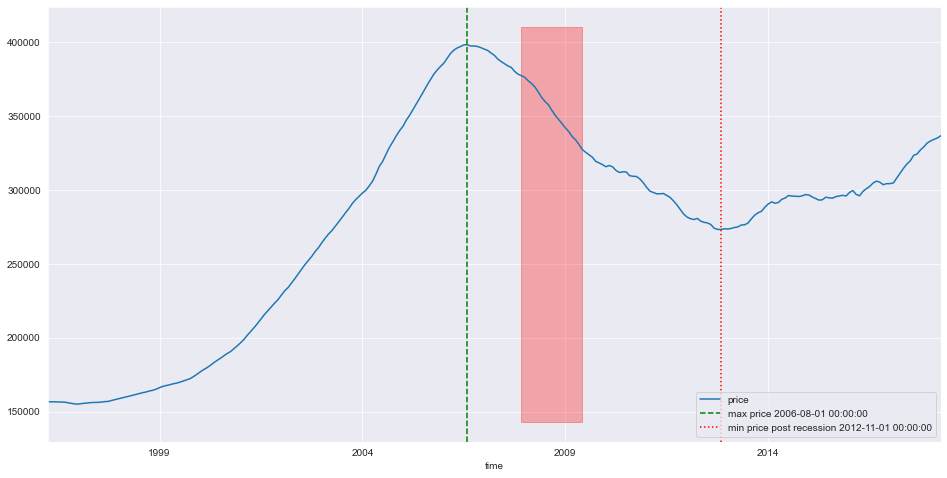

In [8]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Recession = December 2007 – June 2009
# TODO Fix 
fig,ax = plt.subplots(figsize=(16,8))
nj_avg.plot(ax=ax, label='median house prices')
recession = nj_avg.loc['2007-12-01':'2009-06-01']
min_recession = nj_avg.loc['2008':'2014'].price.idxmin()
max_overall = nj_avg.price.idxmax()

ax.fill_between(recession.index, ax.get_ylim()[0], ax.get_ylim()[1], color='red', alpha=0.3)
# plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.12, label='confidence interval')
ax.axvline(max_overall, ls='--', color = 'g', label=f'max price {max_overall}')
ax.axvline(min_recession, ls=':', color = 'r', label=f'min price post recession {min_recession}')

legend=ax.legend(loc='lower right')

# years = np.arange(1996,2019,1)
# print(ax.get_xticklabels())
# print(years)
plt.show()

In [9]:
# not full years in 96 and 2018 
year_groups = nj_avg['1997':'2017'].groupby(pd.Grouper(freq='A'))
temp_annual = pd.DataFrame()
for yr, group in year_groups:
    temp_annual[yr.year] = group.values.ravel()
# temp_annual.plot(figsize=(32,24),subplots=True, legend=True)
# plt.show()

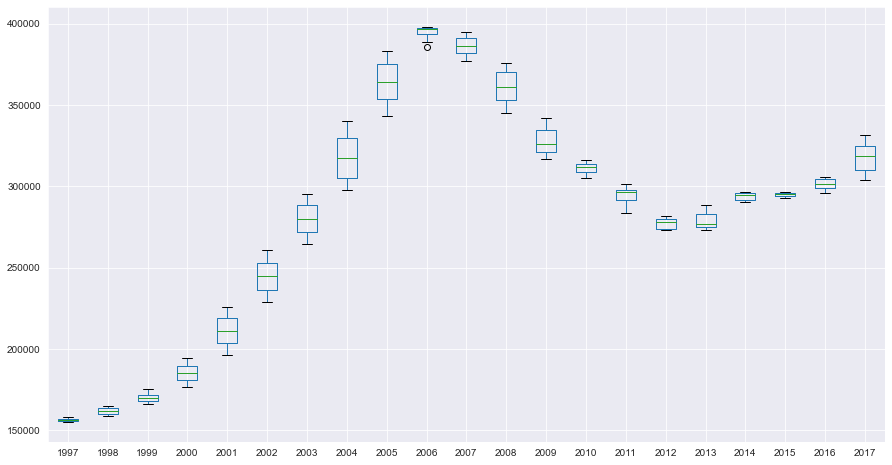

In [10]:
temp_annual.boxplot(figsize=(15,8))
plt.show()

In [11]:
nj_avg_m = nj_avg.resample('MS').sum()
nj_avg_m = nj_avg_m['2012':]['price']

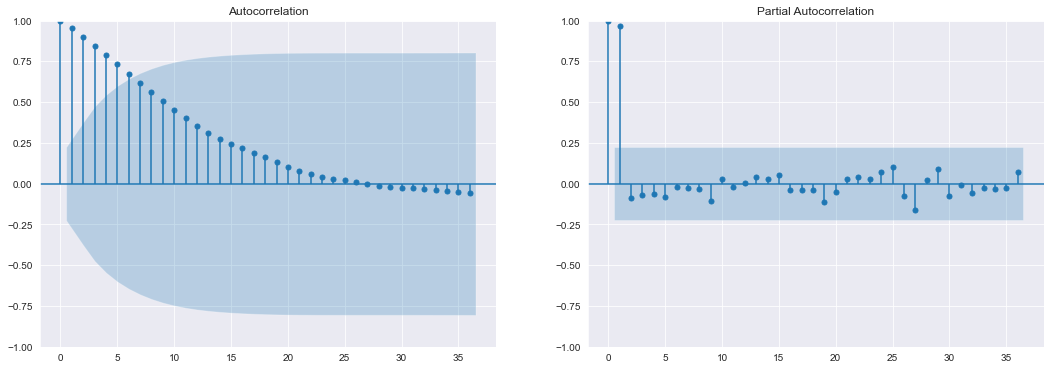

In [12]:
acf_pacf(nj_avg_m)

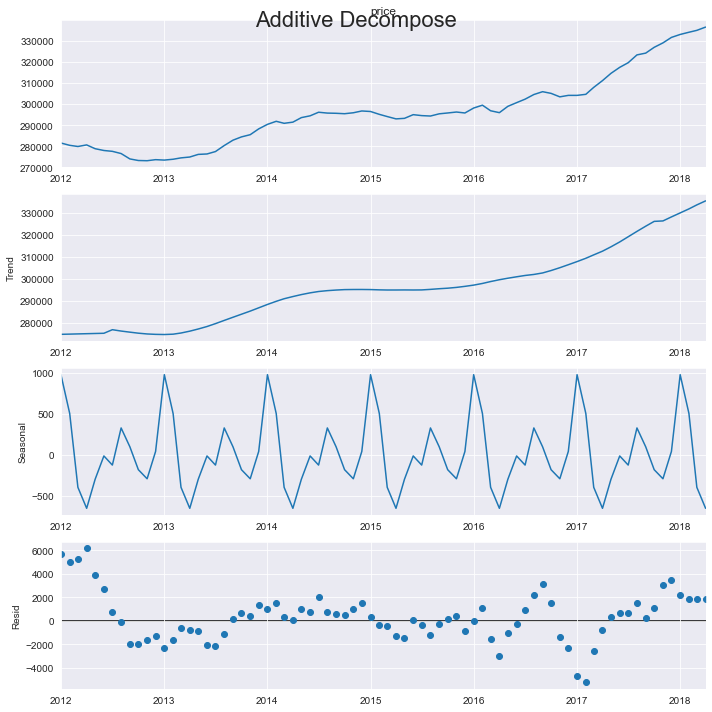

In [13]:
result_add = seasonal_decompose(nj_avg_m, model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

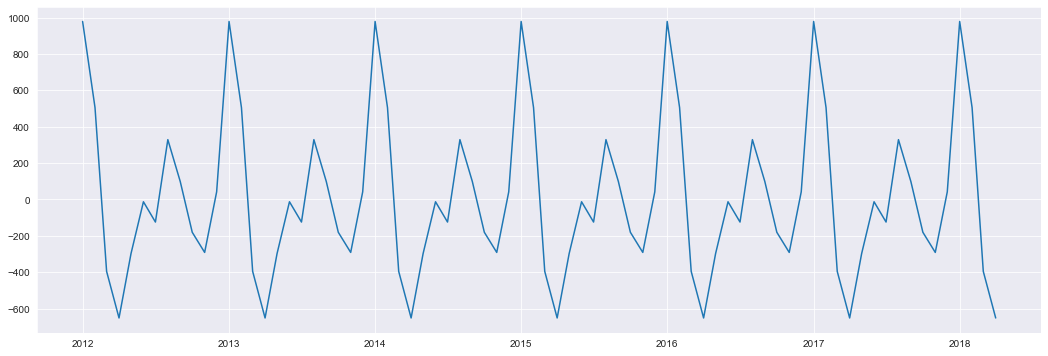

In [14]:
plt.figure(figsize=(18,6))
# TODO add dotted lines 
plt.plot(result_add.seasonal)
plt.show()

## Get top 25 zip codes 

Investor Profile: 
Only interested in suburban areas (lower urbanization). Looking to maximize returns but wants to minimize risk and go with less volatile areas. 

Balance between shorter and longer term returns. 
TODO: add more detail

* Lower urbanization lower 50% of size ranks 
* long term returns (top 200) 
* shorter (3 year) term returns (top 100) 
* top median yearly returns (top 50) 
* lowest volatility / risk (top 25) 

In [82]:

"""
takes in a df and returns only the bottom 50% of zip codes in terms of size rank (urbanization)  
In other words, zip codes that are lower in population 
"""
def lower_urbanization(df):
    return df[df.size_rank > np.median(df.size_rank)]

"""
takes in a df with zipcodes and prices
for each zip code, calculates the ROI over the entire dataset  
returns a dataframe with num_results zip codes sorted by highest ROI  
"""
def rankby_total_roi(df, num_results):
    # get the roi of a series 
    def roi(series):
        return (series.iloc[-1] - series.iloc[0]) / series.iloc[0]
    
    # rank the zips by roi 
    zip_roi = df.groupby('zip').agg({'price':roi}).rename(columns={'price':'roi'}).reset_index().sort_values(by='roi', ascending=False)
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 

"""
Takes in a df with zipcodes and prices
for each zip code, calculates the average yearly roi  
returns a df with num_results zip codes sorted by highest roi
"""
## Median annual ROI 
def rankby_median_annual_roi(df,num_results):
    
    # get the average annual roi of a series 
    def annual_roi(series):
        years = list(df.index.year.unique())
        annual_rois = []
        for index, year in enumerate(years):
            curr_index = int(index * 12) 
            if curr_index != 0:
                curr_year = series.iloc[curr_index]
                prev_year = series.iloc[curr_index - 12]
                annual_roi = (curr_year - prev_year) / prev_year
                annual_rois.append(annual_roi)
        return np.median(annual_rois)
    
    # rank the zips by ROI 
    zip_roi = df.groupby('zip').agg({'price':annual_roi}).rename(columns={'price':'median_annual_roi'}).reset_index()
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result

"""
Takes in a df with zipcodes
Gets the ROI for each zipcode over the past time_horizon years 
returns a DF ranking the top num_results zipcodes 
"""
# Short Term Returns 
def rankby_time_roi(df, time_horizon=3,num_results=10):
    
    def short_roi_calc(series):
        index = series.index[-1] - pd.Timedelta(days=(365*time_horizon))
        index = pd.Timestamp(year=index.year, month=series.index[-1].month,day=series.index[-1].day)
        return (series.iloc[-1] - series[index]) / series[index]
   
    zip_roi = df.groupby('zip').agg({'price':short_roi_calc}).rename(columns={'price':f'{time_horizon}_year_roi'}).reset_index().sort_values(by=f'{time_horizon}_year_roi', ascending=False)
    
    # get only the top num_results zips 
    zips = list(zip_roi.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 


"""
Takes in a df with zipcodes
Gets the coefficient of variation for each zipcode 
returns a DF ranking the top num_results zipcodes (lowest variance)
"""
# Risk/Volatility 
# lowest risk 
def rankby_volatility(df,num_results):
    
    # get the coefficient of variation for a time series 
    def cv_calc(series):
        coef_variation = series.std() / series.mean()
        return coef_variation 
    
    zip_cv = df.groupby('zip').agg({'price':cv_calc}).reset_index().sort_values(by='price', ascending=True).rename(columns={'price':'cv'})
    
    # get only the top num_results zips 
    zips = list(zip_cv.iloc[:num_results,:].zip.unique())
    
    # take original dataframe and filter by only zips above 
    result = df.loc[df['zip'].isin(zips)]
    
    return result 



"""
Takes in a df with zipcodes
returns df with the monthly percent change and the monthly roi for each zip code 
"""

def add_roi(df):
    top_25_pct = pd.DataFrame()

    for z in df.zip.unique():
        curr_df = df[df.zip == z]
        curr_df['monthly_roi'] = curr_df.price.pct_change()
        curr_df['monthly_roi'].iloc[0] = 0.00
        curr_df['roi_multiple'] = curr_df.price.pct_change() + 1.0
        curr_df['roi_multiple'].iloc[0] = 1.00

        top_25_pct = pd.concat([top_25_pct, curr_df])

    # rearrange so dataframe can be further analyzed 
    # if sorted by zip then can't use time indexing 
    top_25_pct = top_25_pct.reset_index().sort_values(by='time',ascending=True)
    top_25_pct = top_25_pct.set_index('time')
    
    return top_25_pct

### Read and Transform Data

In [100]:
data = pd.read_csv('zillow_data.csv')
nj = get_nj(data)
df = melt_df(nj)
df.head()

502 unique zip codes in NJ


,zip,size_rank,city,metro,county,price
time,,,,,,
1996-04-01,7030,58,Hoboken,New York,Hudson,301600.0
1996-04-01,8701,74,Lakewood,New York,Ocean,153800.0
1996-04-01,8753,159,Toms River,New York,Ocean,123400.0
1996-04-01,7002,188,Bayonne,New York,Hudson,145000.0
1996-04-01,7302,192,Jersey City,New York,Hudson,137200.0


### Get Top 25 zip codes 

In [84]:
# suburban zip codes 
lower_urban = lower_urbanization(df) # 251 

# Long Term Returns (200)
long_term_returns = rankby_total_roi(lower_urban, num_results=200)

# # 3 year Returns (100)
three_year_returns = rankby_time_roi(long_term_returns, time_horizon=3, num_results=100)

# # average yearly returns (50)
median_yearly_returns = rankby_median_annual_roi(three_year_returns, num_results=50)

# # lowest volatility (25)
final_df = rankby_volatility(median_yearly_returns, num_results=25)

# print(final_df.zip.nunique())

# add roi column 
final_df = add_roi(final_df) 

# only select data from 2012 onwards 
final_df = final_df['2012':]

final_df.head()

25


,zip,size_rank,city,metro,county,price,monthly_roi,roi_multiple
time,,,,,,,,
2012-01-01,7647,11369,Northvale,New York,Bergen,399700.0,-0.005721,0.994279
2012-01-01,7630,10078,Emerson,New York,Bergen,414300.0,-0.011689,0.988311
2012-01-01,7420,11379,Bloomingdale,New York,Passaic,234400.0,-0.018014,0.981986
2012-01-01,7624,9611,Closter,New York,Bergen,588600.0,-0.009258,0.990742
2012-01-01,7043,8206,Montclair,New York,Essex,592200.0,0.002030,1.002030


In [85]:
# create a dictionary of all zips and towns for displaying information 
zip_dict = {row[1]['zip']:row[1]['city'] for row in final_df.iterrows()}

In [94]:
# # plot monthly roi 
# final_df.groupby('zip')['monthly_roi'].plot(figsize=(22,13),subplots=True, legend=True)
# plt.legend(loc='best')
# plt.show()

# Train Models on All Zip Codes and Get Forecasts

Getting results for zip: 7647


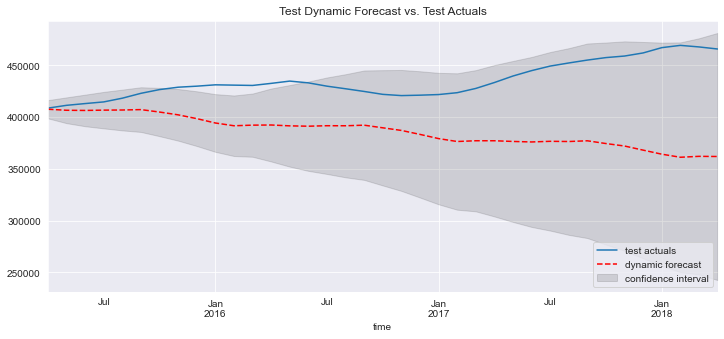

RMSE: 57593.508416542885
Getting results for zip: 7630
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.


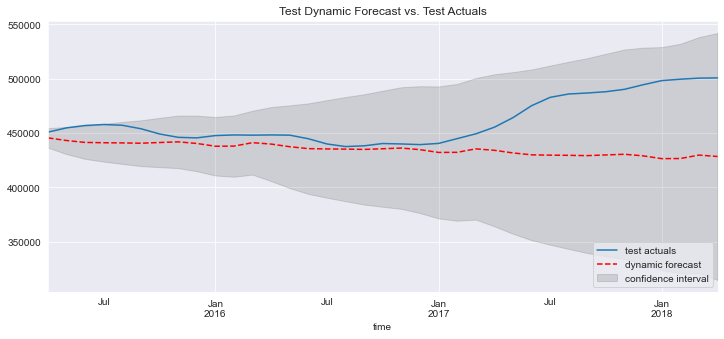

RMSE: 35694.317797132106
Getting results for zip: 7420


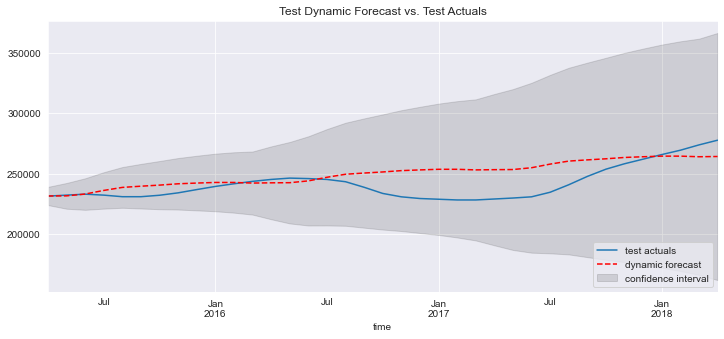

RMSE: 13763.474969761206
Getting results for zip: 7624


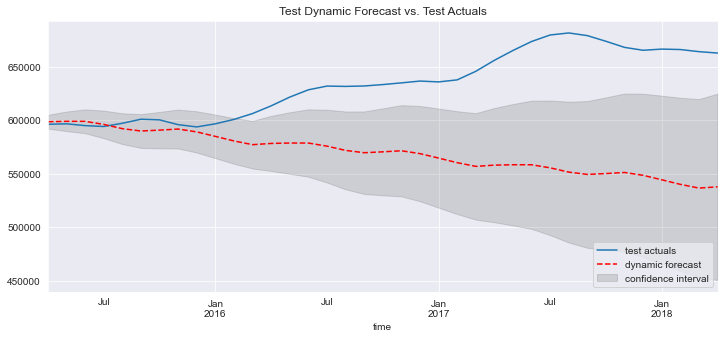

RMSE: 80296.1269243332
Getting results for zip: 7043


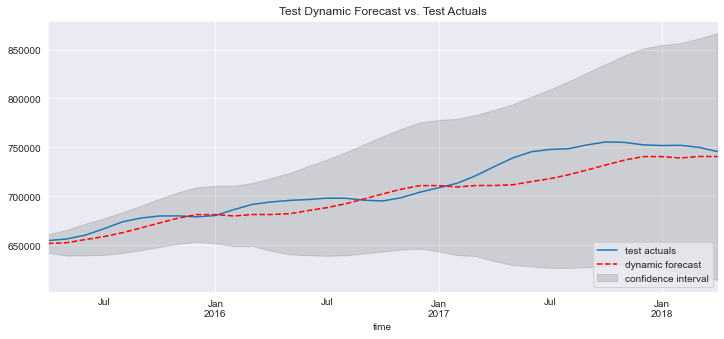

RMSE: 13926.670893008211
Getting results for zip: 7403


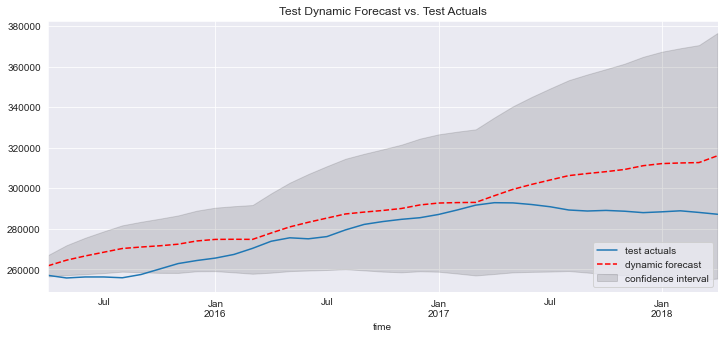

RMSE: 13251.3920579356
Getting results for zip: 7627


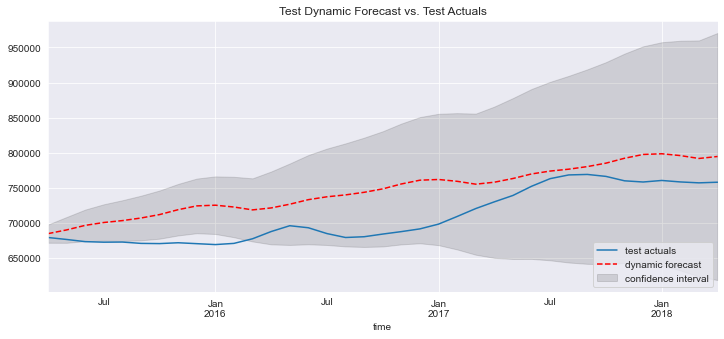

RMSE: 41622.117639410564
Getting results for zip: 7072


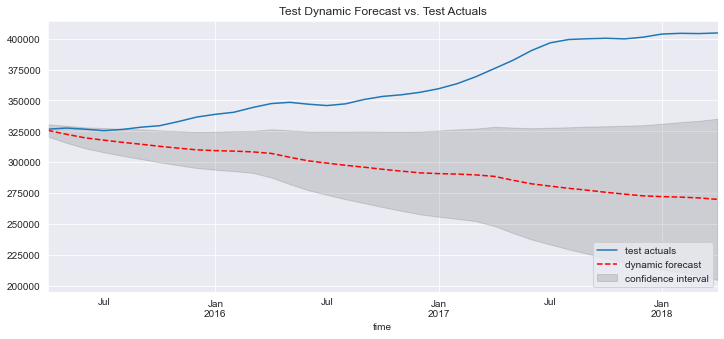

RMSE: 79867.58591131157
Getting results for zip: 7023
Error. Couldn't train model. LU decomposition error.


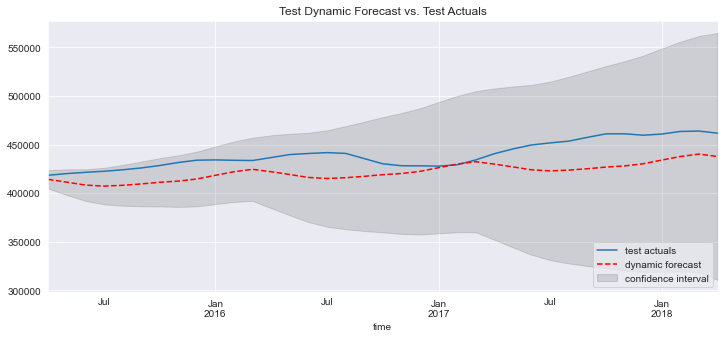

RMSE: 20266.16462132727
Getting results for zip: 7607


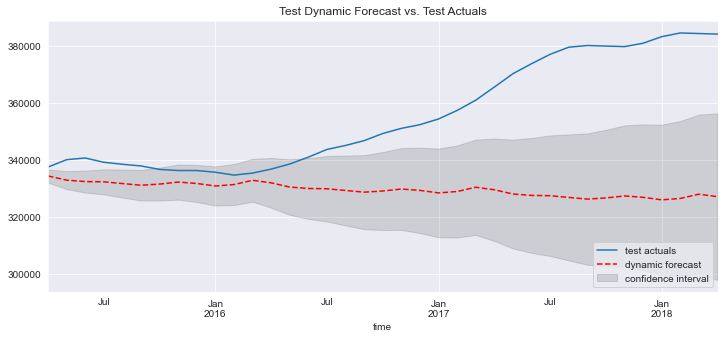

RMSE: 32945.47347542614
Getting results for zip: 7605


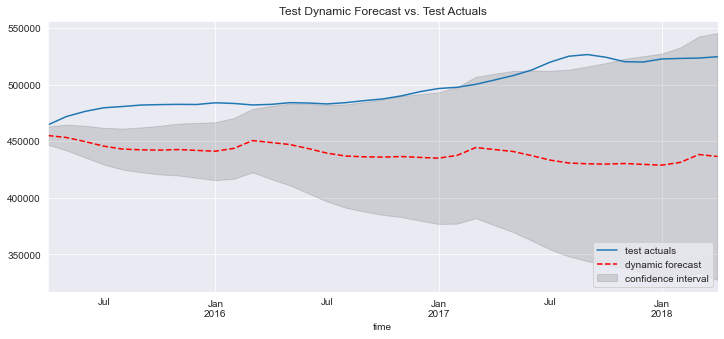

RMSE: 61882.21731102609
Getting results for zip: 7661
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.


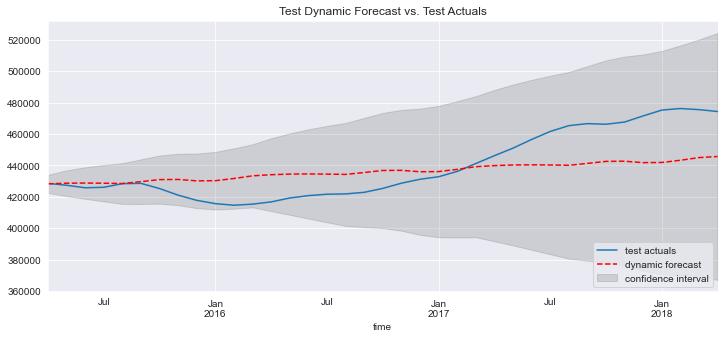

RMSE: 17013.770184688652
Getting results for zip: 7456


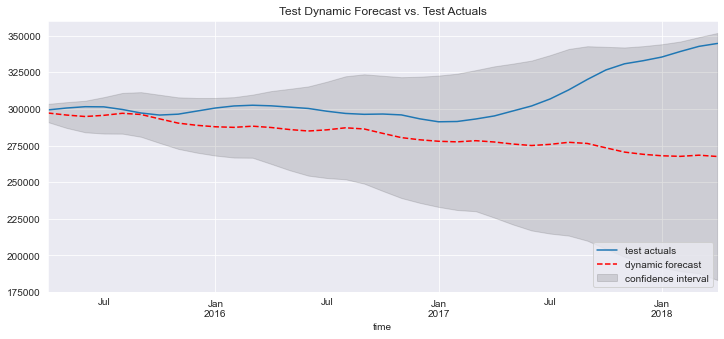

RMSE: 33083.49388392296
Getting results for zip: 7645
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.


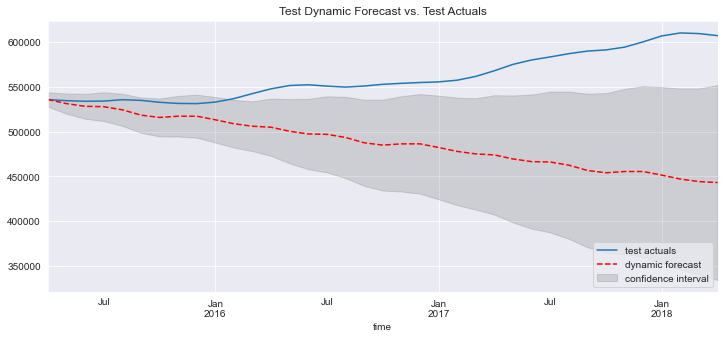

RMSE: 89529.87724172838
Getting results for zip: 7457


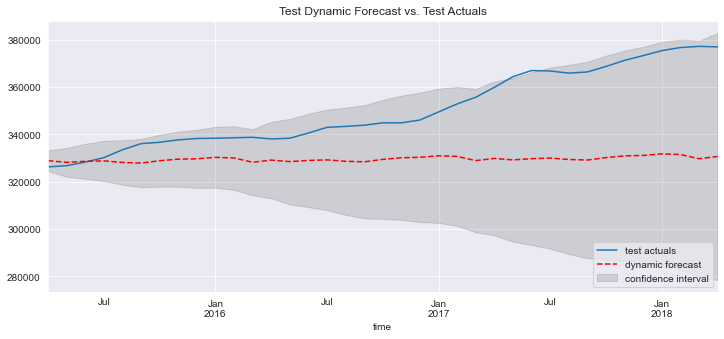

RMSE: 25777.92151121032
Getting results for zip: 7512
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.


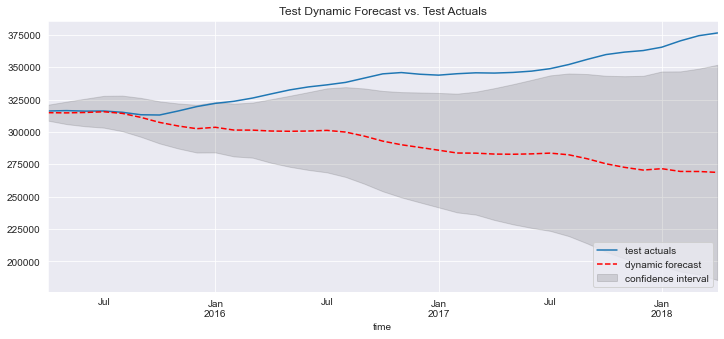

RMSE: 57382.25651670222
Getting results for zip: 7004


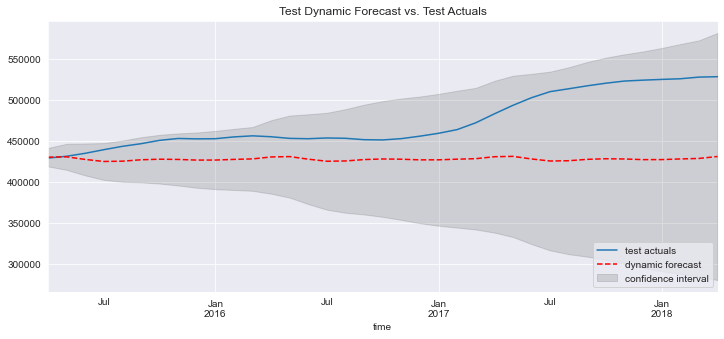

RMSE: 55893.9480026264
Getting results for zip: 7068


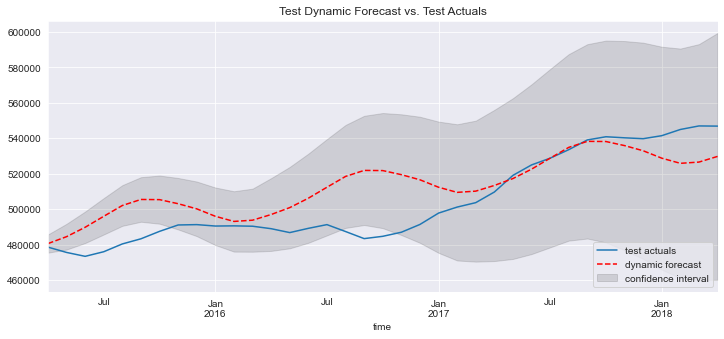

RMSE: 16828.689351287718
Getting results for zip: 7057


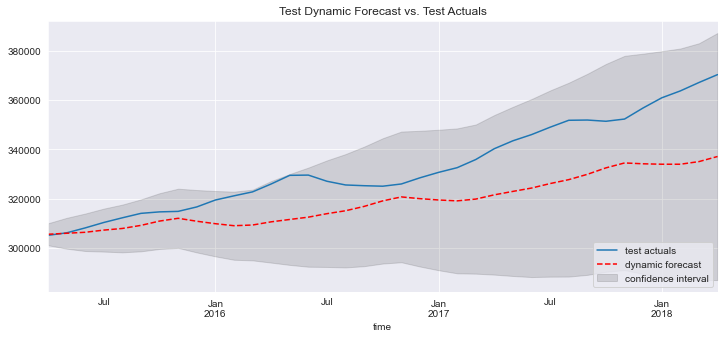

RMSE: 16570.746737318135
Getting results for zip: 7075


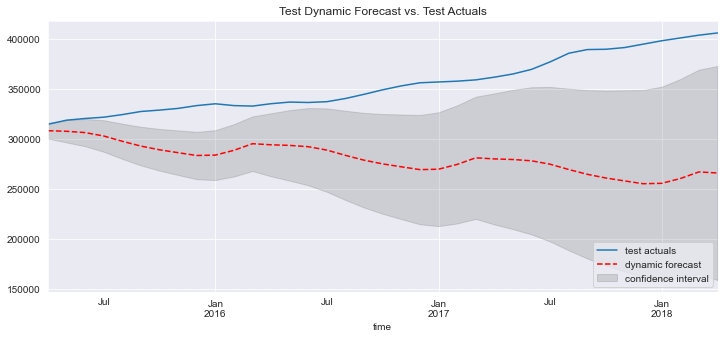

RMSE: 84515.60067086287
Getting results for zip: 7649
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.


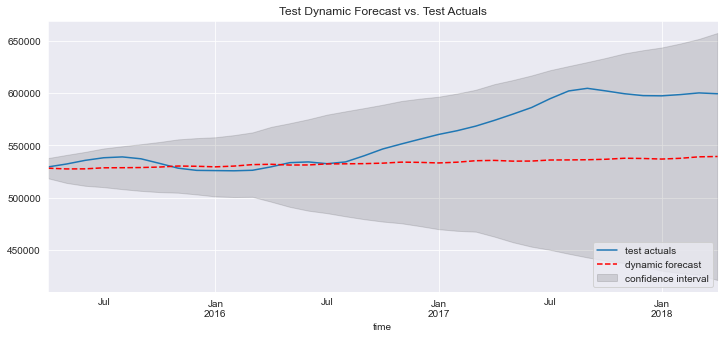

RMSE: 36530.11437444108
Getting results for zip: 7074
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.


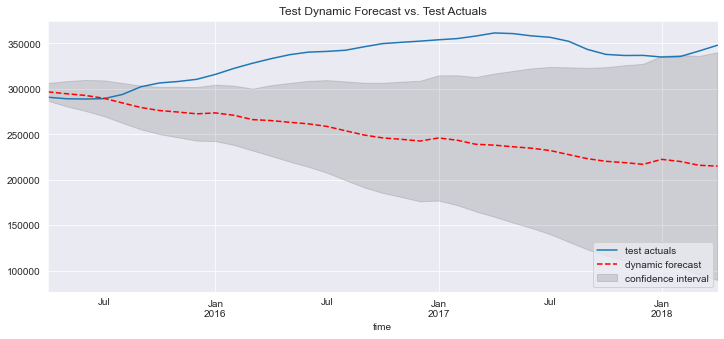

RMSE: 92811.6788851816
Getting results for zip: 7656
Error. Couldn't train model. LU decomposition error.
Error. Couldn't train model. LU decomposition error.


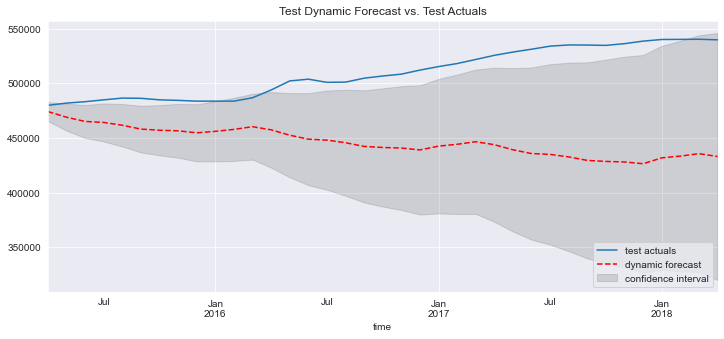

RMSE: 71707.66254031687
Getting results for zip: 7648


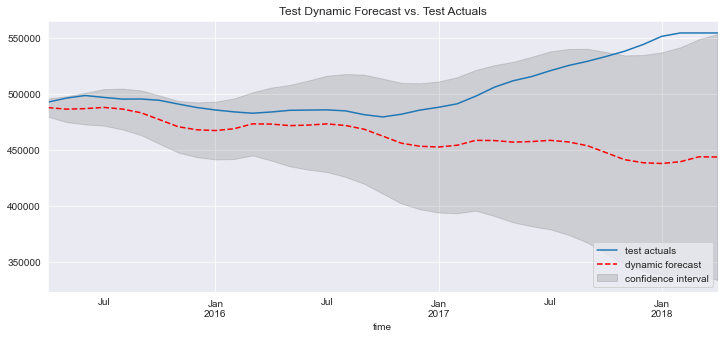

RMSE: 54670.24913484862
Getting results for zip: 7092


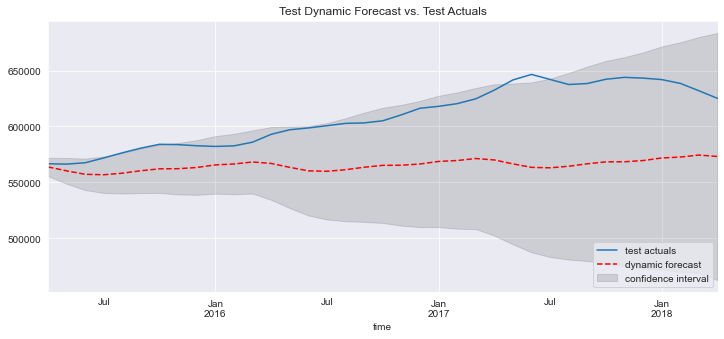

RMSE: 49399.51580898504


In [86]:
results_df = pd.DataFrame()

zips = list(final_df.zip.unique())

for z in zips:  
    # create a df for each zip 
    df = final_df[final_df.zip == z]['price']
    
    # train test split
    train, test = split_train_test(df)
    
    print(f'Getting results for zip: {z}')

    # get the optimal params 
    output_df, pdq, PDQS = get_pdqs_cv(df, train, optimize='aic', display=False) 
    
    # train model using params 
    results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=False, diagnostics=False)
    
    # get the results for train, test and dynamic predictions 
    train_results = train_results_rmse(results, train, display=False)
    test_results = test_results_rmse(train, test, pdq=pdq, PDQS=PDQS, display=False)
    
    # use entire df and get dynamic results 
    dynamic_test_results = test_dynamic_predictions(df, test, pdq, PDQS, display=True)
    
    # forecast results 
    current_price, forecasted_prices, forecasted_rois = forecast_results(df, pdq=pdq, PDQS=PDQS, display=False)
    
    # organize the results into a dataframe 
    current_df = organize_results(z, output_df, train_results, 
                                  test_results, dynamic_test_results,
                                  current_price, forecasted_prices, forecasted_rois)
    
    # aggregate zip codes together 
    results_df = pd.concat([results_df, current_df])

results_df = results_df.set_index('zip')

with open('results_df.pickle','wb') as f:
    pickle.dump(results_df, f)

# Analyze Results

In [87]:
with open('results_df.pickle','rb') as f:
    results_df = pickle.load(f)   

results_df
results_df = results_df.reset_index()

In [88]:
results_df['town'] = results_df.zip.apply(lambda x: zip_dict[x])

### Get Top Long Term Zips 

In [73]:
top_10_yr_df = results_df.sort_values(by='forecast_10yr_roi', ascending=False).iloc[:5,:]
top_5_yr_df = results_df.sort_values(by='forecast_5yr_roi', ascending=False).iloc[:5,:]
print(top_10_yr_df.zip.unique())
print(top_5_yr_df.zip.unique())


[7420 7456 7075 7057 7630]
[7420 7456 7075 7630 7057]


In [74]:
top_10_yr_df

,zip,pdq,pdqs,rmse,aic,train_rmse,test_rmse,dynamic_rmse,current_price,forecast_1yr_price,forecast_3yr_price,forecast_5yr_price,forecast_10yr_price,forecast_1yr_roi,forecast_3yr_roi,forecast_5yr_roi,forecast_10yr_roi,town
2,7420,"(0, 1, 0)","(0, 1, 0, 12)",13763.5,497.762,3347.760445,4251.931199,13763.474970,277600.0,326300.000000,423700.000000,521100.000000,764600.000000,0.175432,0.526297,0.877161,1.754323,Bloomingdale
12,7456,"(0, 1, 0)","(0, 1, 0, 12)",33083.5,486.473,2595.187854,3535.533906,33083.493884,344700.0,394200.000000,493200.000000,592200.000000,839700.000000,0.143603,0.430809,0.718016,1.436031,Ringwood
19,7075,"(0, 1, 0)","(0, 1, 0, 12)",84515.6,510.349,4354.977995,3951.154467,84515.600671,405700.0,449900.000000,538300.000000,626700.000000,847700.000000,0.108947,0.326842,0.544737,1.089475,Wood Ridge
18,7057,"(1, 1, 1)","(0, 1, 0, 12)",37551.8,475.123,1959.924775,2324.707559,16570.746737,370300.0,401902.325062,468556.686380,538250.536684,718974.925253,0.085342,0.265343,0.453553,0.941601,Wallington
1,7630,"(1, 1, 1)","(1, 1, 0, 12)",35855.6,502.573,3316.106497,5295.899951,35694.317797,500800.0,546366.285443,637499.303415,728632.324529,956464.877315,0.090987,0.272962,0.454937,0.909874,Emerson


In [96]:
long_term_df = top_10_yr_df[['zip','town','forecast_5yr_roi','forecast_10yr_roi']]
long_term_df

,zip,town,forecast_5yr_roi,forecast_10yr_roi
2,7420,Bloomingdale,0.877161,1.754323
12,7456,Ringwood,0.718016,1.436031
19,7075,Wood Ridge,0.544737,1.089475
18,7057,Wallington,0.453553,0.941601
1,7630,Emerson,0.454937,0.909874


Getting results for zip: 7420
                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -247.881
Date:                            Sat, 26 Mar 2022   AIC                            497.762
Time:                                    15:42:38   BIC                            499.020
Sample:                                01-01-2012   HQIC                           498.124
                                     - 03-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.073e+07    3.4e+06      3.152      0.002    4.06e+06    1.74e+07
Ljung

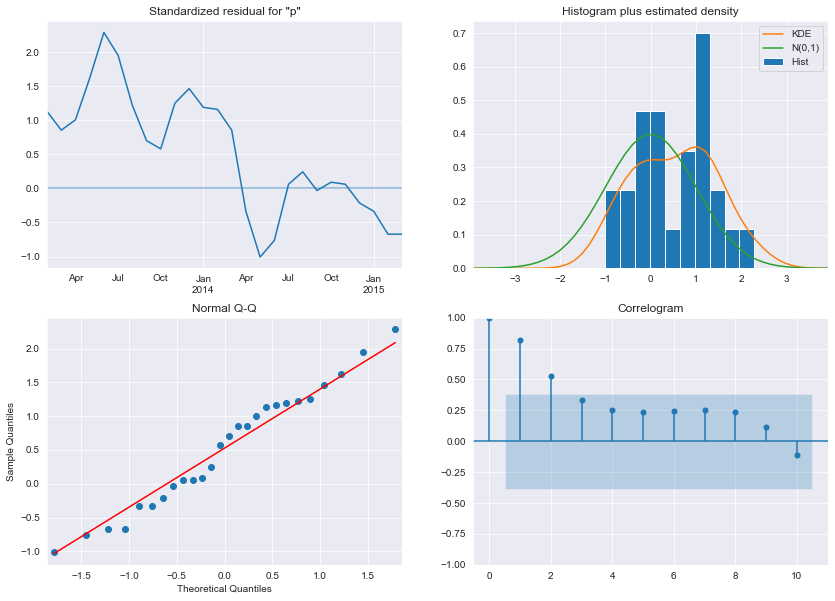

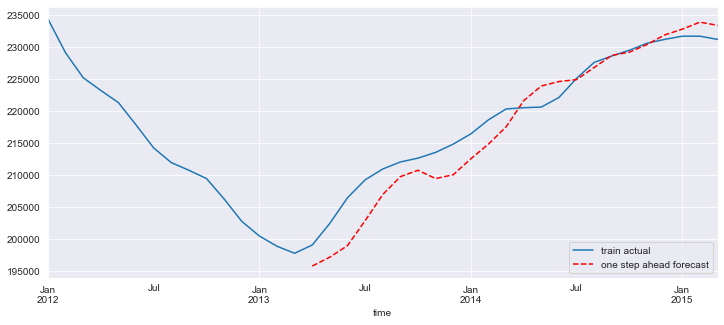

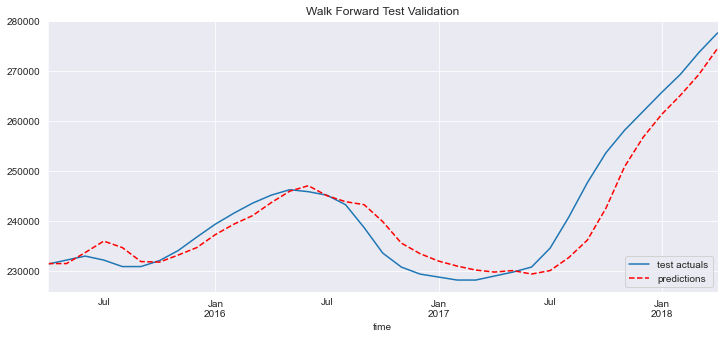

Test RMSE: 4251.9311987518


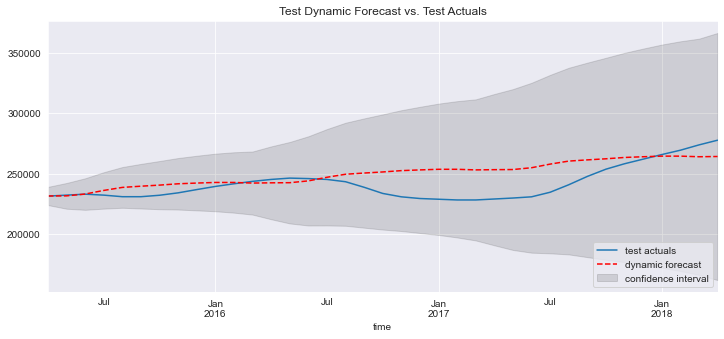

RMSE: 13763.474969761206
Current price: $277600.0, Price after 1 year(s): $326300.0
ROI for 1 year(s):0.17543227665706052

Current price: $277600.0, Price after 3 year(s): $423700.0
ROI for 3 year(s):0.5262968299711815

Current price: $277600.0, Price after 5 year(s): $521100.0
ROI for 5 year(s):0.8771613832853026

Current price: $277600.0, Price after 10 year(s): $764600.0
ROI for 10 year(s):1.7543227665706052



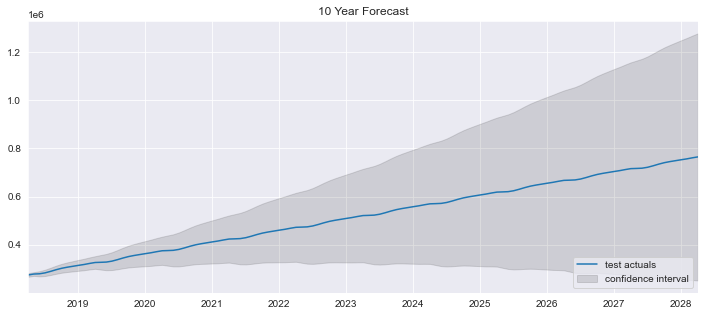

In [98]:
single_zip_analysis(final_df, 7420, display=True)

In [ ]:
# TODO plot on Map 

### Get Top Short Term Zips 

In [76]:
top_1_yr_df = results_df.sort_values(by='forecast_1yr_price', ascending=False).iloc[:5,:]
top_3_yr_df = results_df.sort_values(by='forecast_3yr_price', ascending=False).iloc[:5,:]

print(top_1_yr_df.zip.unique())
print(top_3_yr_df.zip.unique())

[7627 7043 7624 7645 7649]
[7627 7043 7645 7648 7624]


In [77]:
top_3_yr_df

,zip,pdq,pdqs,rmse,aic,train_rmse,test_rmse,dynamic_rmse,current_price,forecast_1yr_price,forecast_3yr_price,forecast_5yr_price,forecast_10yr_price,forecast_1yr_roi,forecast_3yr_roi,forecast_5yr_roi,forecast_10yr_roi,town
6,7627,"(1, 1, 1)","(0, 1, 0, 12)",42539.5,496.545,3067.699057,8247.269292,41622.117639,757700.0,785700.000000,841700.000000,897700.000000,1.037700e+06,0.036954,0.110862,0.184770,0.369539,Demarest
4,7043,"(0, 1, 0)","(0, 1, 0, 12)",13926.7,512.35,4570.877013,5066.557016,13926.670893,745800.0,761100.000000,791700.000000,822300.000000,8.988000e+05,0.020515,0.061545,0.102574,0.205149,Montclair
13,7645,"(0, 1, 0)","(0, 1, 0, 12)",89529.9,510.736,4124.570685,4033.206758,89529.877242,606800.0,645900.000000,724100.000000,802300.000000,9.978000e+05,0.064436,0.193309,0.322182,0.644364,Montvale
23,7648,"(0, 1, 0)","(1, 1, 0, 12)",54809.6,521.547,4814.219565,4473.910665,54670.249135,554600.0,602728.591392,698991.346992,795254.074282,1.035911e+06,0.086781,0.260352,0.433924,0.867852,Norwood
3,7624,"(0, 1, 1)","(1, 1, 0, 12)",80376.5,532.792,5827.585804,5371.782034,80296.126924,662800.0,669855.912427,683966.190020,698076.469944,7.333522e+05,0.010646,0.031935,0.053223,0.106446,Closter


In [78]:
top_1_yr_df

,zip,pdq,pdqs,rmse,aic,train_rmse,test_rmse,dynamic_rmse,current_price,forecast_1yr_price,forecast_3yr_price,forecast_5yr_price,forecast_10yr_price,forecast_1yr_roi,forecast_3yr_roi,forecast_5yr_roi,forecast_10yr_roi,town
6,7627,"(1, 1, 1)","(0, 1, 0, 12)",42539.5,496.545,3067.699057,8247.269292,41622.117639,757700.0,785700.000000,841700.000000,897700.000000,1.037700e+06,0.036954,0.110862,0.184770,0.369539,Demarest
4,7043,"(0, 1, 0)","(0, 1, 0, 12)",13926.7,512.35,4570.877013,5066.557016,13926.670893,745800.0,761100.000000,791700.000000,822300.000000,8.988000e+05,0.020515,0.061545,0.102574,0.205149,Montclair
3,7624,"(0, 1, 1)","(1, 1, 0, 12)",80376.5,532.792,5827.585804,5371.782034,80296.126924,662800.0,669855.912427,683966.190020,698076.469944,7.333522e+05,0.010646,0.031935,0.053223,0.106446,Closter
13,7645,"(0, 1, 0)","(0, 1, 0, 12)",89529.9,510.736,4124.570685,4033.206758,89529.877242,606800.0,645900.000000,724100.000000,802300.000000,9.978000e+05,0.064436,0.193309,0.322182,0.644364,Montvale
20,7649,"(1, 1, 1)","(1, 1, 0, 12)",36585.5,518.932,4577.364139,5139.562806,36530.114374,599500.0,626674.955485,681036.038795,735397.332834,8.713006e+05,0.045329,0.136007,0.226684,0.453379,Oradell


In [97]:
short_term_df = top_3_yr_df[['zip','town','forecast_1yr_price','forecast_3yr_price']]
short_term_df

,zip,town,forecast_1yr_price,forecast_3yr_price
6,7627,Demarest,785700.000000,841700.000000
4,7043,Montclair,761100.000000,791700.000000
13,7645,Montvale,645900.000000,724100.000000
23,7648,Norwood,602728.591392,698991.346992
3,7624,Closter,669855.912427,683966.190020


Getting results for zip: 7627
                                      SARIMAX Results                                      
Dep. Variable:                               price   No. Observations:                   39
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -245.273
Date:                             Sat, 26 Mar 2022   AIC                            496.545
Time:                                     14:24:42   BIC                            500.320
Sample:                                 01-01-2012   HQIC                           497.632
                                      - 03-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6712      0.198      3.396      0.001       0.284       1.0

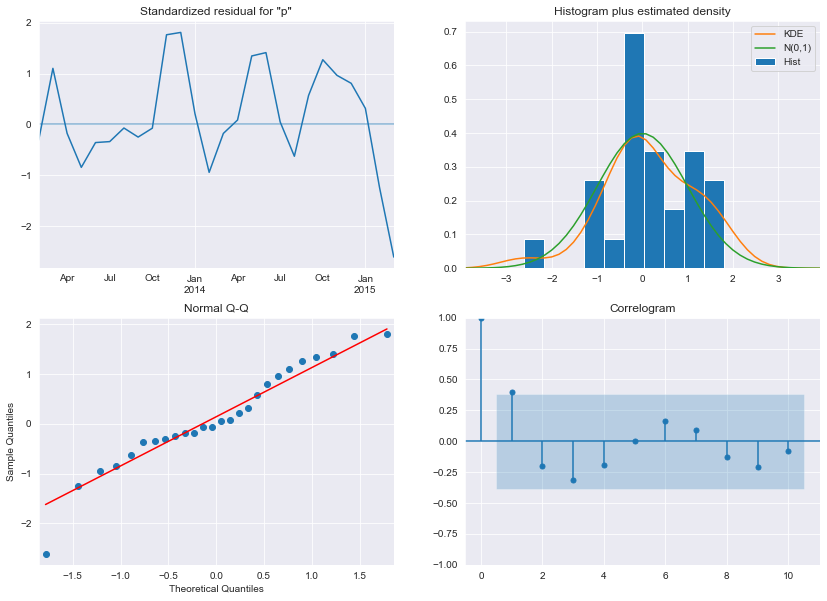

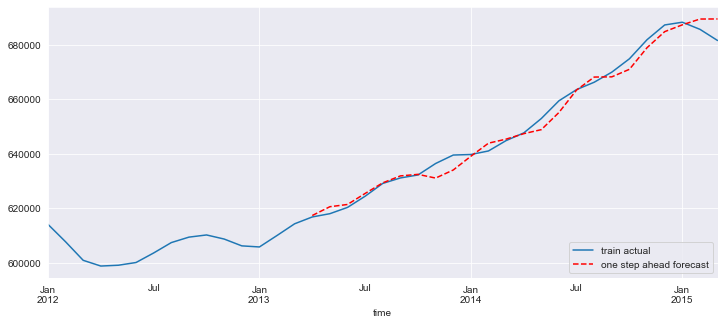

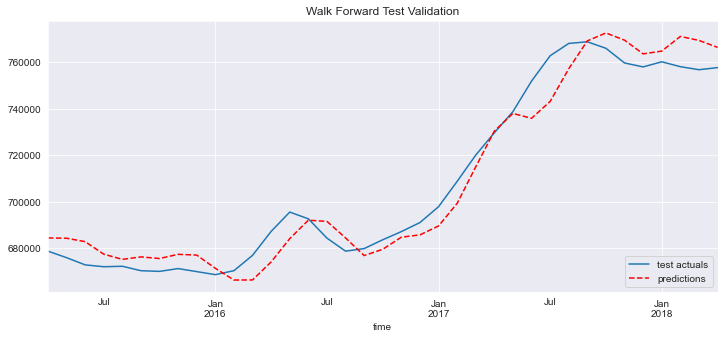

Test RMSE: 8247.26929200701


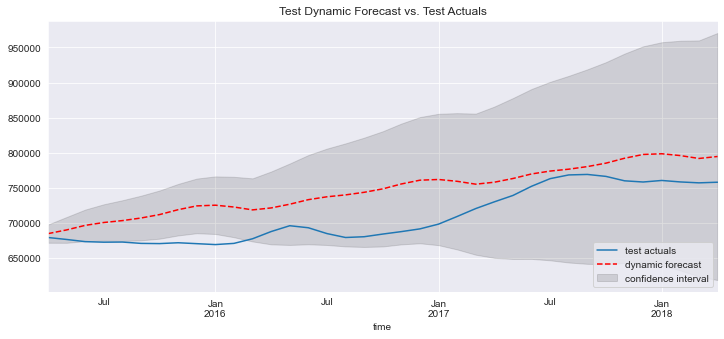

RMSE: 41622.117639410564
Current price: $757700.0, Price after 1 year(s): $785700.0
ROI for 1 year(s):0.03695393955391562

Current price: $757700.0, Price after 3 year(s): $841700.0
ROI for 3 year(s):0.11086181866175483

Current price: $757700.0, Price after 5 year(s): $897700.0
ROI for 5 year(s):0.18476969776960528

Current price: $757700.0, Price after 10 year(s): $1037700.0
ROI for 10 year(s):0.36953939553927756



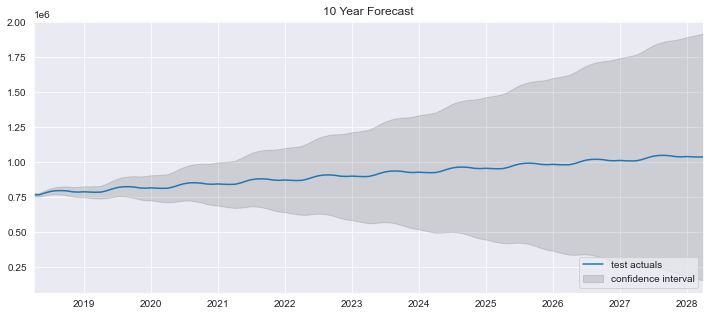

In [93]:
single_zip_analysis(final_df, 7627, display=True)

In [ ]:
# TODO 

# boolean exogenous in recession variable
# testing on extra 2018 - 2021 data 
# start post recession in 2012 
# go all the way back to 96 and use boolean 

In [59]:
# Notice the points fall along a line in the middle of the graph, 
# but curve off in the extremities. Normal Q-Q plots that exhibit this 
# behavior usually mean your data have more extreme values than would be expected if they truly came from a Normal distribution.
# https://data.library.virginia.edu/understanding-q-q-plots/


# All Zillow Data

In [101]:
data = pd.read_csv('zhvi_sfh_all.csv')

nj = get_nj(data)
nj = nj.drop(['RegionType','StateName'], axis=1)

df = melt_df(nj)
df.head()

3763 missing values.
587 unique zip codes in NJ


,zip,size_rank,city,metro,county,price
time,,,,,,
2000-01-31,7030,67,Hoboken,New York-Newark-Jersey City,Hudson County,454071.0
2000-01-31,8701,83,Lakewood Township,New York-Newark-Jersey City,Ocean County,182641.0
2000-01-31,7302,113,Jersey City,New York-Newark-Jersey City,Hudson County,258113.0
2000-01-31,8753,202,Toms River,New York-Newark-Jersey City,Ocean County,140962.0
2000-01-31,7002,227,Bayonne,New York-Newark-Jersey City,Hudson County,178311.0


## Get Top 25 zip codes 

In [102]:
# suburban zip codes 
lower_urban = lower_urbanization(df) # 251 

# Long Term Returns (200)
long_term_returns = rankby_total_roi(lower_urban, num_results=200)

# # 3 year Returns (100)
three_year_returns = rankby_time_roi(long_term_returns, time_horizon=3, num_results=100)

# # average yearly returns (50)
median_yearly_returns = rankby_median_annual_roi(three_year_returns, num_results=50)

# # lowest volatility (25)
final_df = rankby_volatility(median_yearly_returns, num_results=25)

# print(final_df.zip.nunique())

# add roi column 
final_df = add_roi(final_df) 

# only select data from 2012 onwards 
final_df = final_df['2013':]

final_df.head()

,zip,size_rank,city,metro,county,price,monthly_roi,roi_multiple
time,,,,,,,,
2013-01-31,8029,13760,Glendora,Philadelphia-Camden-Wilmington,Camden County,150927.0,-0.002900,0.997100
2013-01-31,7416,12863,Franklin,New York-Newark-Jersey City,Sussex County,186983.0,-0.002800,0.997200
2013-01-31,7821,10727,Byram Township,New York-Newark-Jersey City,Sussex County,260499.0,-0.000652,0.999348
2013-01-31,7014,13664,Clifton,New York-Newark-Jersey City,Passaic County,290482.0,-0.002291,0.997709
2013-01-31,7737,15111,Middletown Township,New York-Newark-Jersey City,Monmouth County,300524.0,0.005746,1.005746


In [103]:
# create a dictionary of all zips and towns for displaying information 
zip_dict = {row[1]['zip']:row[1]['city'] for row in final_df.iterrows()}

In [94]:
# # plot monthly roi 
# final_df.groupby('zip')['monthly_roi'].plot(figsize=(22,13),subplots=True, legend=True)
# plt.legend(loc='best')
# plt.show()

# Train Models on All Zip Codes and Get Forecasts

Getting results for zip: 8029


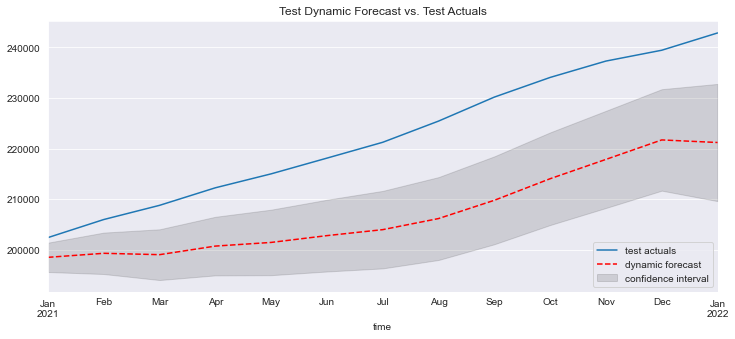

RMSE: 16054.086208813007
Getting results for zip: 7416


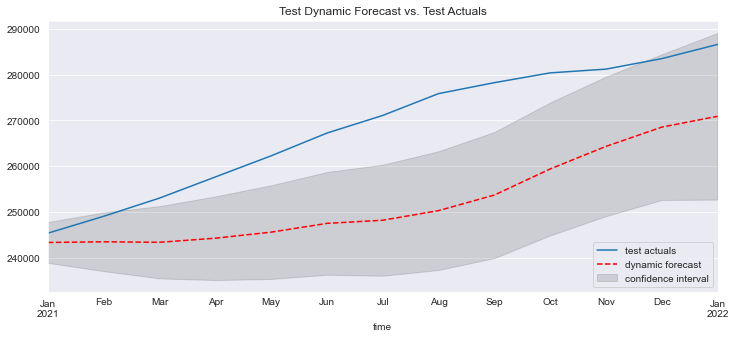

RMSE: 17459.1557478747
Getting results for zip: 7821


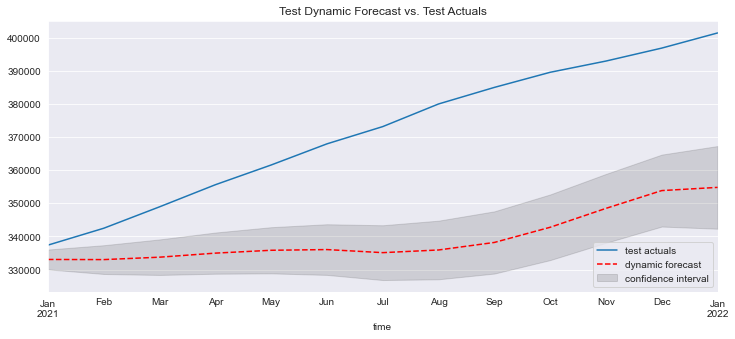

RMSE: 35288.9573165578
Getting results for zip: 7014


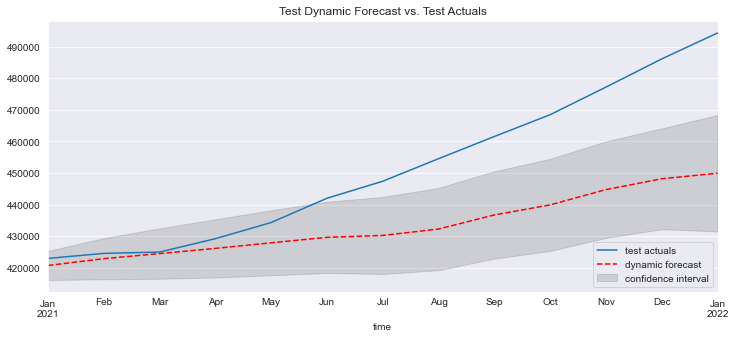

RMSE: 23042.834746485645
Getting results for zip: 7737


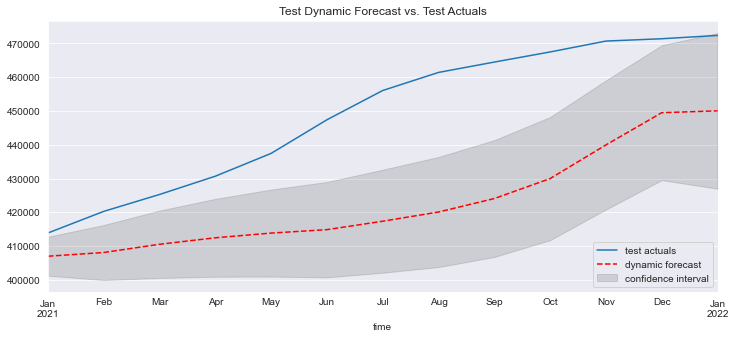

RMSE: 28452.19539724618
Getting results for zip: 7826


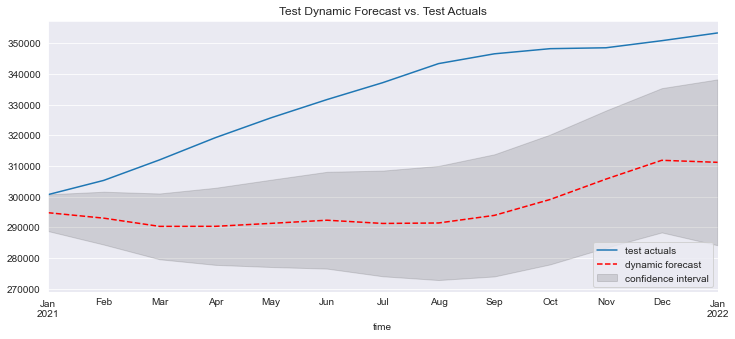

RMSE: 38604.63280110354
Getting results for zip: 8049
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.


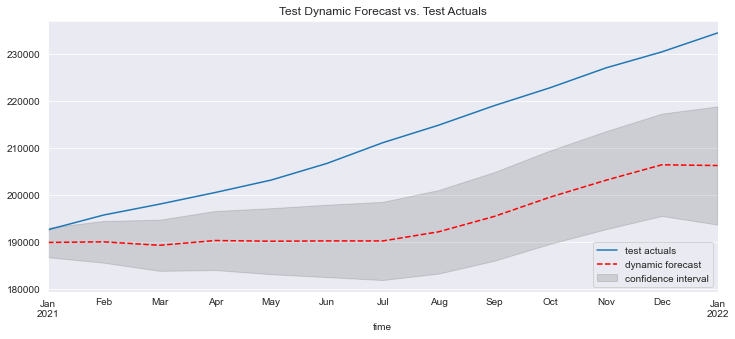

RMSE: 18905.35018291017
Getting results for zip: 7421


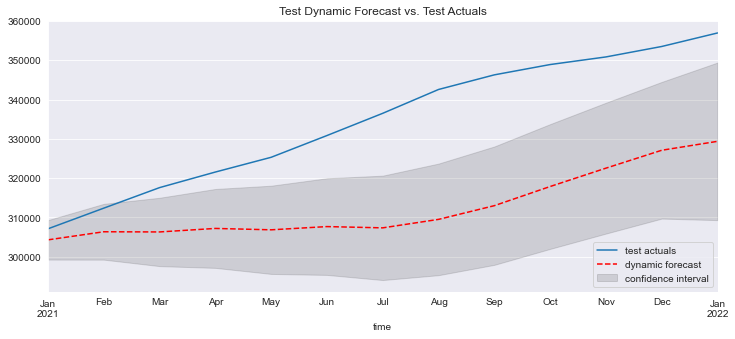

RMSE: 24064.780432884443
Getting results for zip: 8056


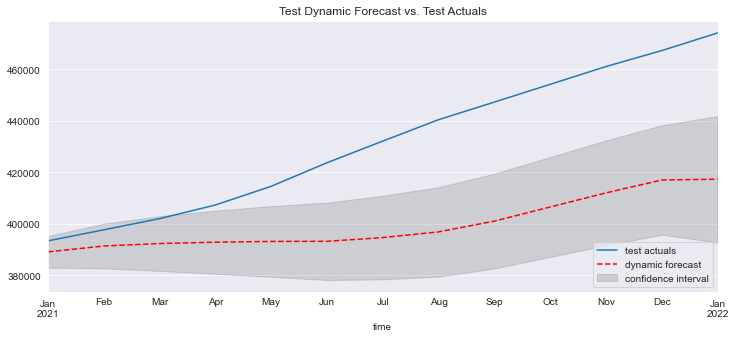

RMSE: 36808.200807909256
Getting results for zip: 7832


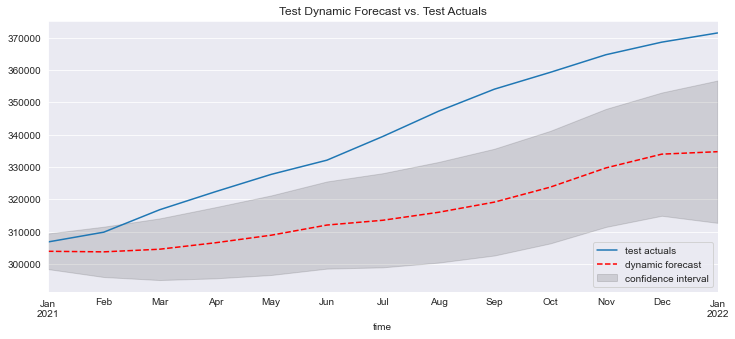

RMSE: 26491.924978697247
Getting results for zip: 7760


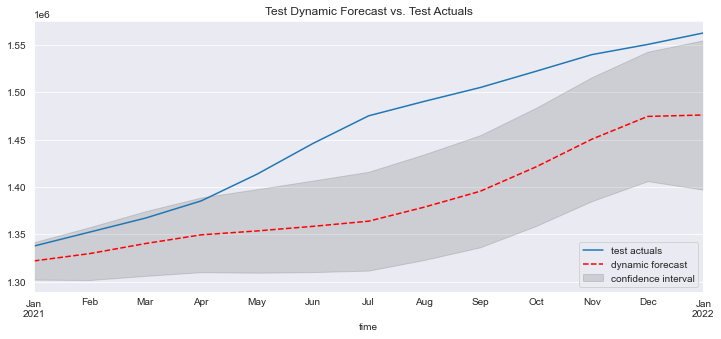

RMSE: 79607.70319317265
Getting results for zip: 7848


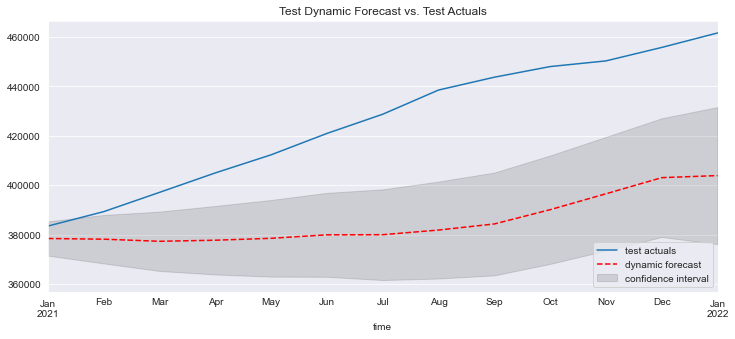

RMSE: 44370.732829137414
Getting results for zip: 8039


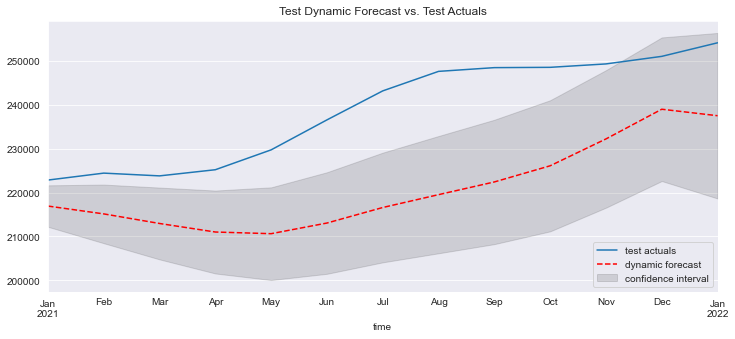

RMSE: 19099.399125667613
Getting results for zip: 8061


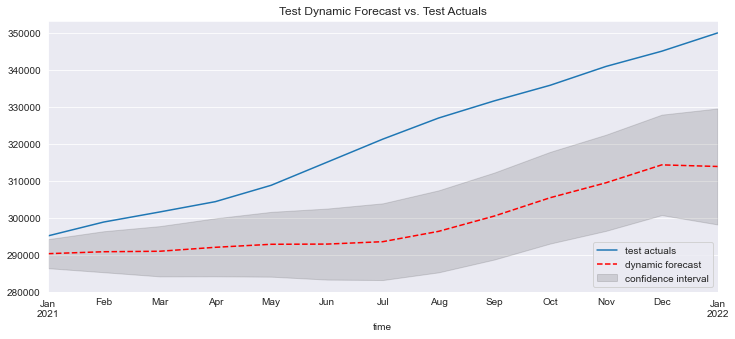

RMSE: 24692.873132514604
Getting results for zip: 8068


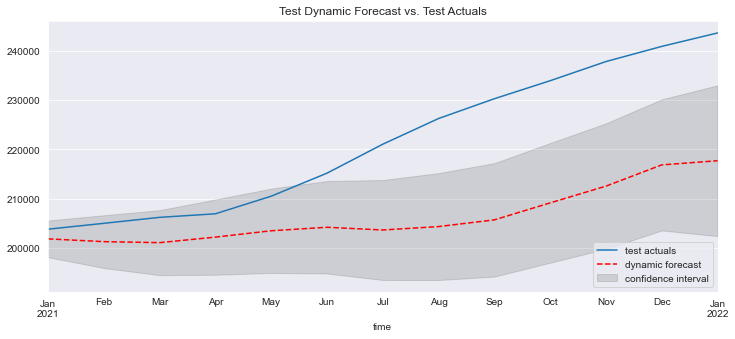

RMSE: 17844.11464881759
Getting results for zip: 8020


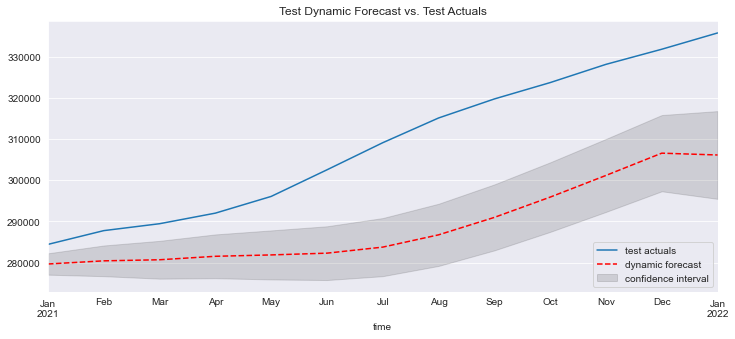

RMSE: 21807.12637566831
Getting results for zip: 8071


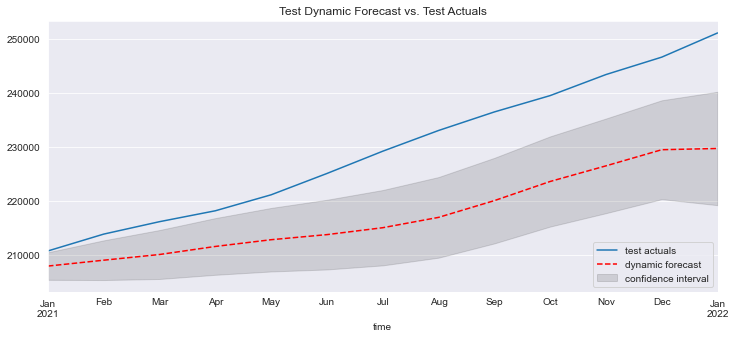

RMSE: 13401.039573948965
Getting results for zip: 7439
LinAlgError, 'Singular matrix'.
LinAlgError, 'Singular matrix'.


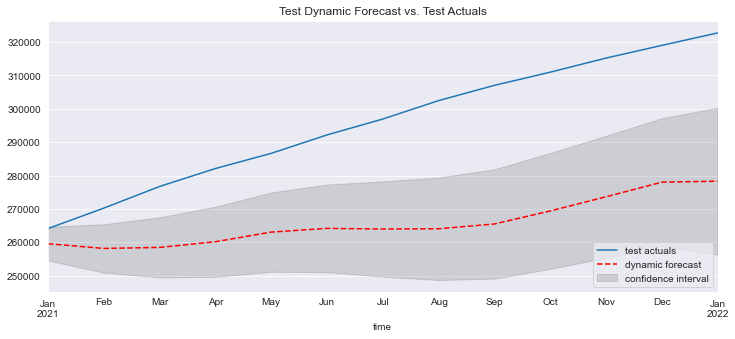

RMSE: 32457.679530762864
Getting results for zip: 7827


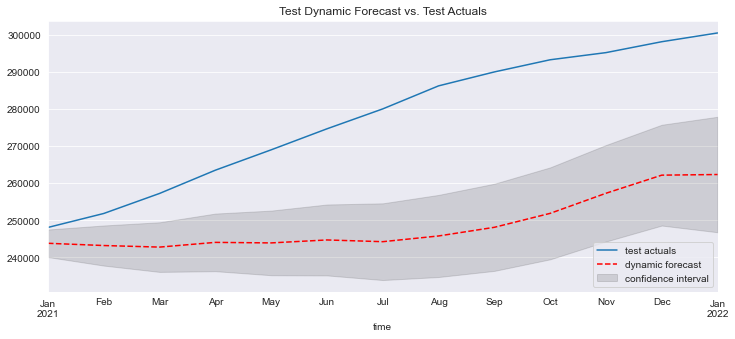

RMSE: 31396.44013277823
Getting results for zip: 8007


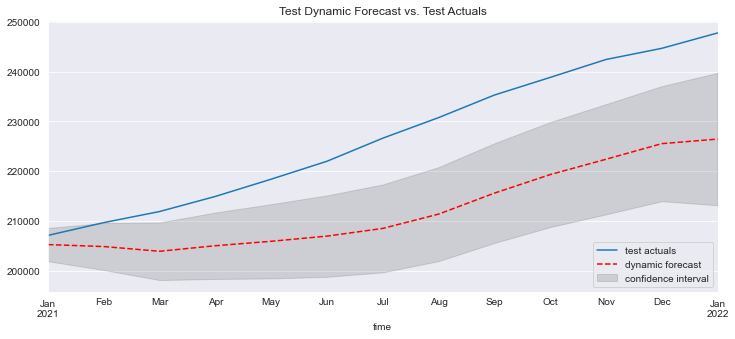

RMSE: 15831.358042168622
Getting results for zip: 8059


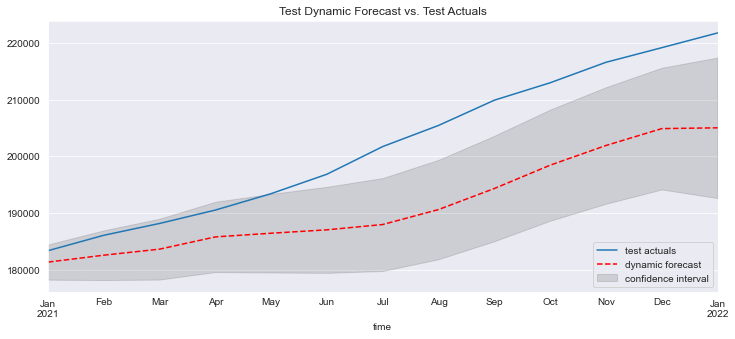

RMSE: 11645.882402080013
Getting results for zip: 7874


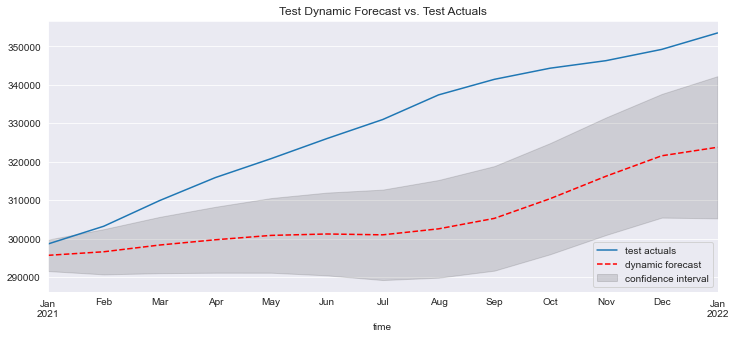

RMSE: 25716.14272084781
Getting results for zip: 7758


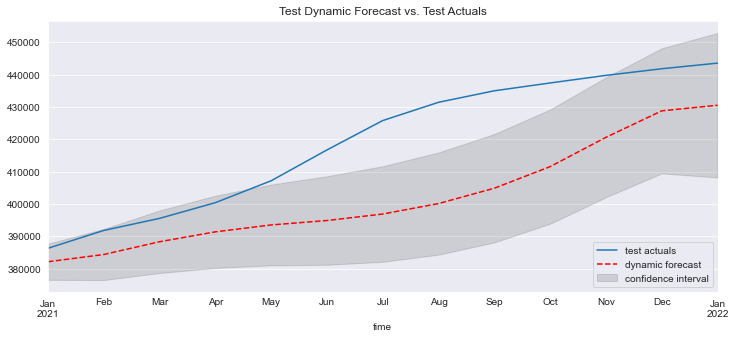

RMSE: 19553.62311105619
Getting results for zip: 8065


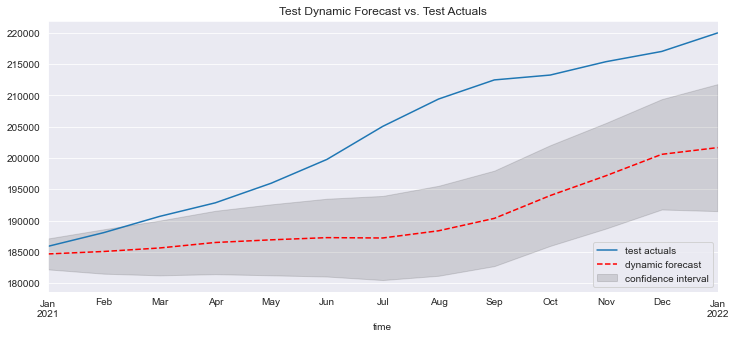

RMSE: 14858.337388065005
Getting results for zip: 7838


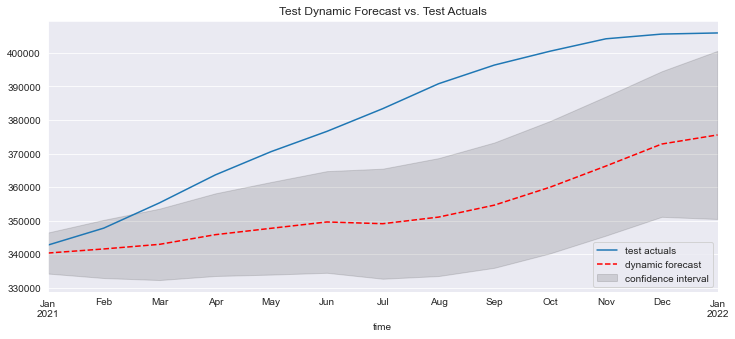

RMSE: 29568.30648956112


In [110]:
results_df = pd.DataFrame()

zips = list(final_df.zip.unique())

for z in zips:  
    # create a df for each zip 
    df = final_df[final_df.zip == z]['price']
    
    # train test split
    train, test = split_train_test(df,'2020-12-31')
    
    print(f'Getting results for zip: {z}')

    # get the optimal params 
    output_df, pdq, PDQS = get_pdqs_cv(df, train, optimize='aic', display=False) 
    
    # train model using params 
    results = train_sarimax(train, pdq=pdq, PDQS=PDQS, summary=False, diagnostics=False)
    
    # get the results for train, test and dynamic predictions 
    train_results = train_results_rmse(results, train, display=False)
    test_results = test_results_rmse(train, test, pdq=pdq, PDQS=PDQS, display=False)
    
    # use entire df and get dynamic results 
    dynamic_test_results = test_dynamic_predictions(df, test, pdq, PDQS, display=True)
    
    # forecast results 
    current_price, forecasted_prices, forecasted_rois = forecast_results(df, pdq=pdq, PDQS=PDQS, display=False)
    
    # organize the results into a dataframe 
    current_df = organize_results(z, output_df, train_results, 
                                  test_results, dynamic_test_results,
                                  current_price, forecasted_prices, forecasted_rois)
    
    # aggregate zip codes together 
    results_df = pd.concat([results_df, current_df])

results_df = results_df.set_index('zip')

# with open('results_df.pickle','wb') as f:
#     pickle.dump(results_df, f)

# Analyze Results

In [111]:
# with open('results_df.pickle','rb') as f:
#     results_df = pickle.load(f)   

results_df
results_df = results_df.reset_index()

In [106]:
results_df['town'] = results_df.zip.apply(lambda x: zip_dict[x])

### Get Top Long Term Zips 

In [107]:
top_10_yr_df = results_df.sort_values(by='forecast_10yr_roi', ascending=False).iloc[:5,:]
top_5_yr_df = results_df.sort_values(by='forecast_5yr_roi', ascending=False).iloc[:5,:]
print(top_10_yr_df.zip.unique())
print(top_5_yr_df.zip.unique())


[7832 7439 7827 8059 8056]
[7832 7439 7827 8059 8056]


In [108]:
top_10_yr_df

,zip,pdq,pdqs,rmse,aic,train_rmse,test_rmse,dynamic_rmse,current_price,forecast_1yr_price,forecast_3yr_price,forecast_5yr_price,forecast_10yr_price,forecast_1yr_roi,forecast_3yr_roi,forecast_5yr_roi,forecast_10yr_roi,town
9,7832,"(1, 1, 1)","(0, 1, 0, 12)",25709.9,242.839,42624.815128,2935.705119,63486.833067,371481.0,440145.731838,585163.626980,736159.076703,1.124024e+06,0.184840,0.575218,0.981687,2.025791,Knowlton Township
17,7439,"(0, 1, 0)","(0, 1, 0, 12)",36031.4,234.287,33340.684176,2839.651771,24029.342047,322697.0,381269.000000,498413.000000,615557.000000,9.084170e+05,0.181508,0.544523,0.907539,1.815077,Ogdensburg
18,7827,"(0, 1, 0)","(0, 1, 0, 12)",54477.2,251.705,32730.023133,2791.490202,47945.316863,300581.0,353075.000000,458063.000000,563051.000000,8.255210e+05,0.174642,0.523925,0.873209,1.746418,Montague Township
20,8059,"(0, 1, 0)","(1, 1, 1, 12)",25703.4,218.454,17996.540944,1614.093325,30923.989568,221739.0,260022.419212,336653.606958,413279.446063,6.048402e+05,0.172651,0.518243,0.863810,1.727712,Mount Ephraim
8,8056,"(0, 1, 0)","(0, 1, 0, 12)",40093.2,238.52,53669.054117,2943.884598,48896.184063,474182.0,554914.000000,716378.000000,877842.000000,1.281502e+06,0.170255,0.510766,0.851277,1.702553,East Greenwich Township


In [109]:
long_term_df = top_10_yr_df[['zip','town','forecast_5yr_roi','forecast_10yr_roi']]
long_term_df

,zip,town,forecast_5yr_roi,forecast_10yr_roi
9,7832,Knowlton Township,0.981687,2.025791
17,7439,Ogdensburg,0.907539,1.815077
18,7827,Montague Township,0.873209,1.746418
20,8059,Mount Ephraim,0.863810,1.727712
8,8056,East Greenwich Township,0.851277,1.702553


Getting results for zip: 7420
                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -247.881
Date:                            Sat, 26 Mar 2022   AIC                            497.762
Time:                                    15:42:38   BIC                            499.020
Sample:                                01-01-2012   HQIC                           498.124
                                     - 03-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.073e+07    3.4e+06      3.152      0.002    4.06e+06    1.74e+07
Ljung

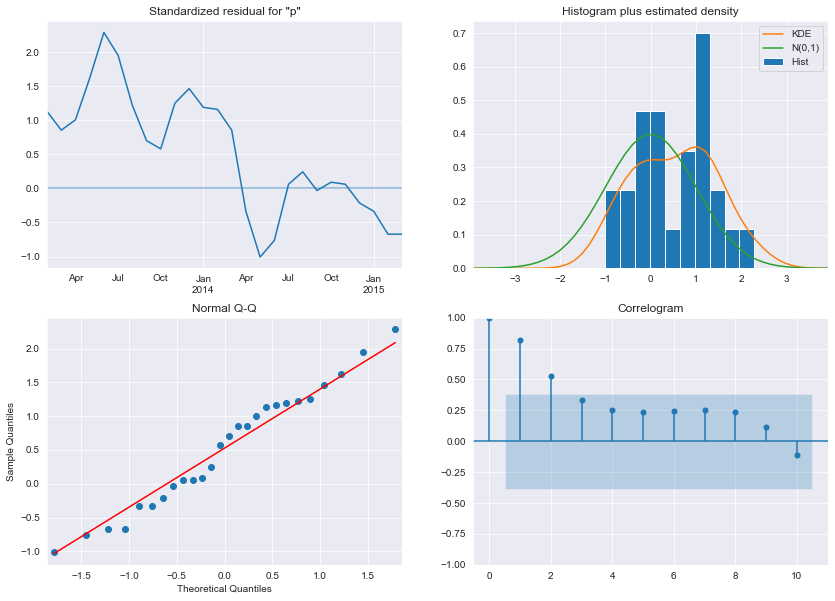

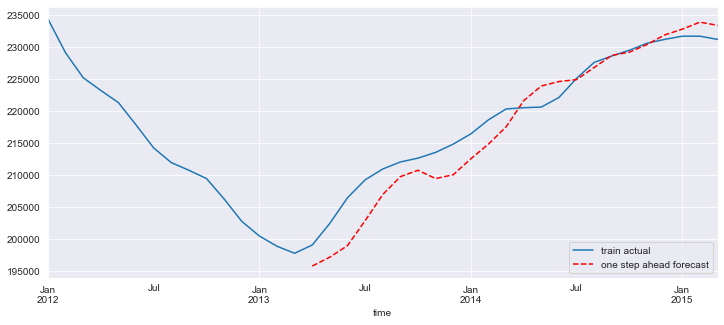

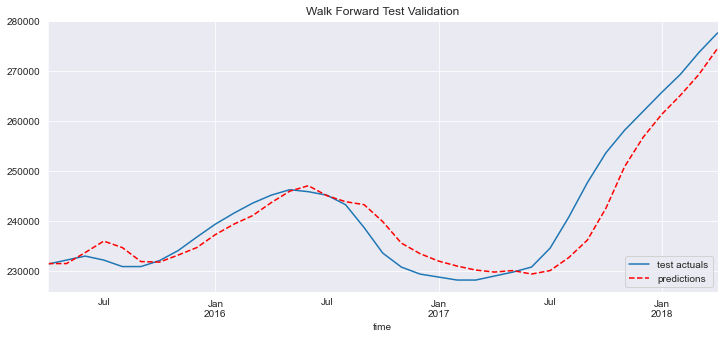

Test RMSE: 4251.9311987518


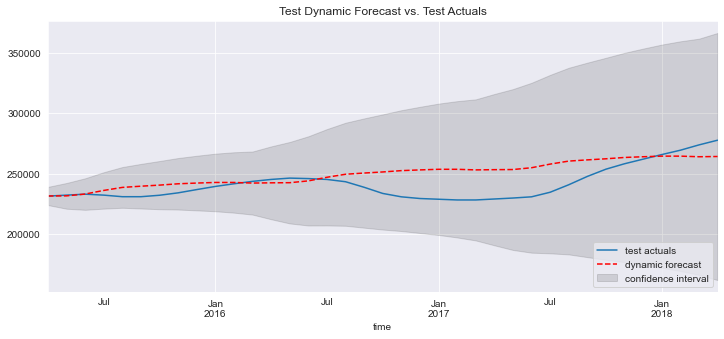

RMSE: 13763.474969761206
Current price: $277600.0, Price after 1 year(s): $326300.0
ROI for 1 year(s):0.17543227665706052

Current price: $277600.0, Price after 3 year(s): $423700.0
ROI for 3 year(s):0.5262968299711815

Current price: $277600.0, Price after 5 year(s): $521100.0
ROI for 5 year(s):0.8771613832853026

Current price: $277600.0, Price after 10 year(s): $764600.0
ROI for 10 year(s):1.7543227665706052



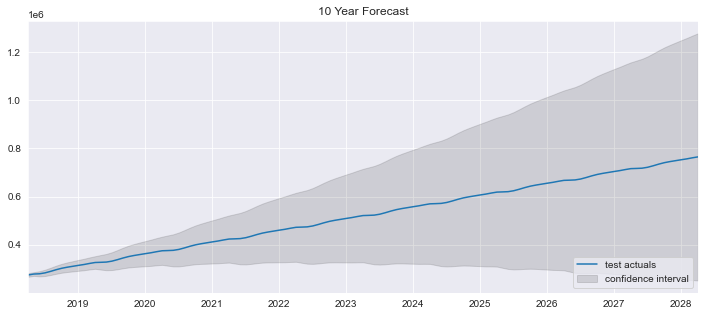

In [98]:
single_zip_analysis(final_df, 8056, display=True)

In [ ]:
# TODO plot on Map 

### Get Top Short Term Zips 

In [76]:
top_1_yr_df = results_df.sort_values(by='forecast_1yr_price', ascending=False).iloc[:5,:]
top_3_yr_df = results_df.sort_values(by='forecast_3yr_price', ascending=False).iloc[:5,:]

print(top_1_yr_df.zip.unique())
print(top_3_yr_df.zip.unique())

[7627 7043 7624 7645 7649]
[7627 7043 7645 7648 7624]


In [77]:
top_3_yr_df

,zip,pdq,pdqs,rmse,aic,train_rmse,test_rmse,dynamic_rmse,current_price,forecast_1yr_price,forecast_3yr_price,forecast_5yr_price,forecast_10yr_price,forecast_1yr_roi,forecast_3yr_roi,forecast_5yr_roi,forecast_10yr_roi,town
6,7627,"(1, 1, 1)","(0, 1, 0, 12)",42539.5,496.545,3067.699057,8247.269292,41622.117639,757700.0,785700.000000,841700.000000,897700.000000,1.037700e+06,0.036954,0.110862,0.184770,0.369539,Demarest
4,7043,"(0, 1, 0)","(0, 1, 0, 12)",13926.7,512.35,4570.877013,5066.557016,13926.670893,745800.0,761100.000000,791700.000000,822300.000000,8.988000e+05,0.020515,0.061545,0.102574,0.205149,Montclair
13,7645,"(0, 1, 0)","(0, 1, 0, 12)",89529.9,510.736,4124.570685,4033.206758,89529.877242,606800.0,645900.000000,724100.000000,802300.000000,9.978000e+05,0.064436,0.193309,0.322182,0.644364,Montvale
23,7648,"(0, 1, 0)","(1, 1, 0, 12)",54809.6,521.547,4814.219565,4473.910665,54670.249135,554600.0,602728.591392,698991.346992,795254.074282,1.035911e+06,0.086781,0.260352,0.433924,0.867852,Norwood
3,7624,"(0, 1, 1)","(1, 1, 0, 12)",80376.5,532.792,5827.585804,5371.782034,80296.126924,662800.0,669855.912427,683966.190020,698076.469944,7.333522e+05,0.010646,0.031935,0.053223,0.106446,Closter


In [78]:
top_1_yr_df

,zip,pdq,pdqs,rmse,aic,train_rmse,test_rmse,dynamic_rmse,current_price,forecast_1yr_price,forecast_3yr_price,forecast_5yr_price,forecast_10yr_price,forecast_1yr_roi,forecast_3yr_roi,forecast_5yr_roi,forecast_10yr_roi,town
6,7627,"(1, 1, 1)","(0, 1, 0, 12)",42539.5,496.545,3067.699057,8247.269292,41622.117639,757700.0,785700.000000,841700.000000,897700.000000,1.037700e+06,0.036954,0.110862,0.184770,0.369539,Demarest
4,7043,"(0, 1, 0)","(0, 1, 0, 12)",13926.7,512.35,4570.877013,5066.557016,13926.670893,745800.0,761100.000000,791700.000000,822300.000000,8.988000e+05,0.020515,0.061545,0.102574,0.205149,Montclair
3,7624,"(0, 1, 1)","(1, 1, 0, 12)",80376.5,532.792,5827.585804,5371.782034,80296.126924,662800.0,669855.912427,683966.190020,698076.469944,7.333522e+05,0.010646,0.031935,0.053223,0.106446,Closter
13,7645,"(0, 1, 0)","(0, 1, 0, 12)",89529.9,510.736,4124.570685,4033.206758,89529.877242,606800.0,645900.000000,724100.000000,802300.000000,9.978000e+05,0.064436,0.193309,0.322182,0.644364,Montvale
20,7649,"(1, 1, 1)","(1, 1, 0, 12)",36585.5,518.932,4577.364139,5139.562806,36530.114374,599500.0,626674.955485,681036.038795,735397.332834,8.713006e+05,0.045329,0.136007,0.226684,0.453379,Oradell


In [97]:
short_term_df = top_3_yr_df[['zip','town','forecast_1yr_price','forecast_3yr_price']]
short_term_df

,zip,town,forecast_1yr_price,forecast_3yr_price
6,7627,Demarest,785700.000000,841700.000000
4,7043,Montclair,761100.000000,791700.000000
13,7645,Montvale,645900.000000,724100.000000
23,7648,Norwood,602728.591392,698991.346992
3,7624,Closter,669855.912427,683966.190020


Getting results for zip: 7627
                                      SARIMAX Results                                      
Dep. Variable:                               price   No. Observations:                   39
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -245.273
Date:                             Sat, 26 Mar 2022   AIC                            496.545
Time:                                     14:24:42   BIC                            500.320
Sample:                                 01-01-2012   HQIC                           497.632
                                      - 03-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6712      0.198      3.396      0.001       0.284       1.0

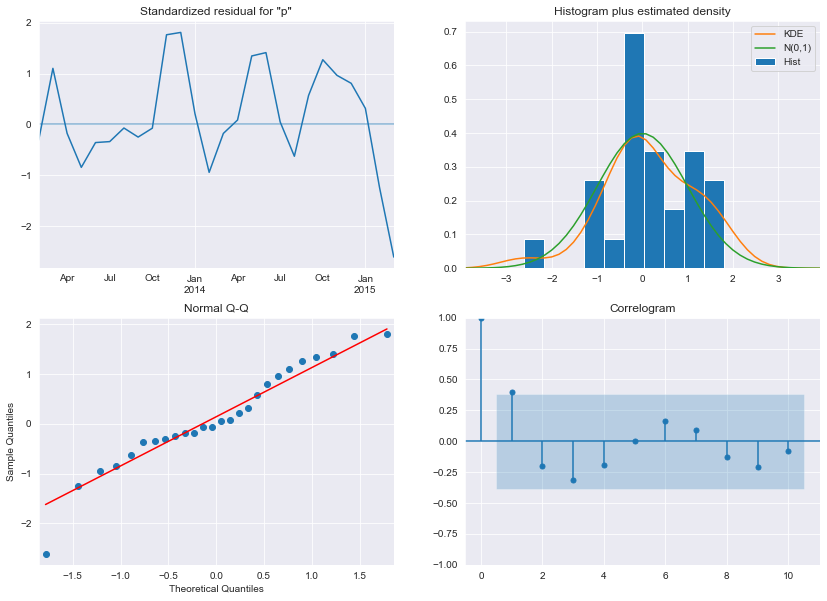

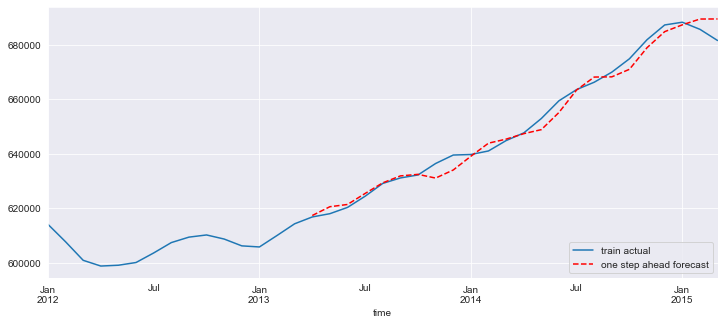

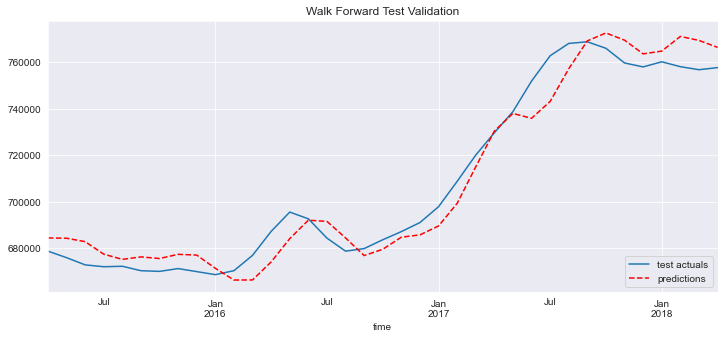

Test RMSE: 8247.26929200701


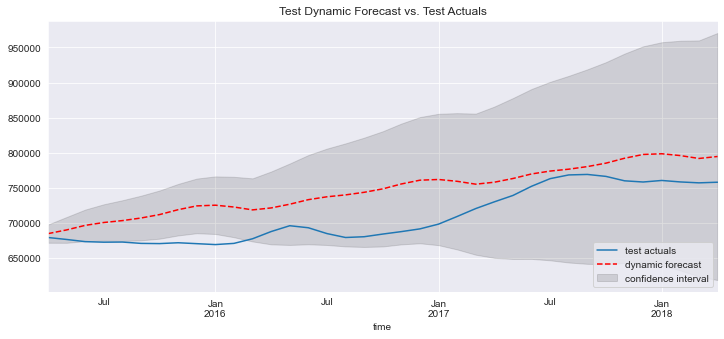

RMSE: 41622.117639410564
Current price: $757700.0, Price after 1 year(s): $785700.0
ROI for 1 year(s):0.03695393955391562

Current price: $757700.0, Price after 3 year(s): $841700.0
ROI for 3 year(s):0.11086181866175483

Current price: $757700.0, Price after 5 year(s): $897700.0
ROI for 5 year(s):0.18476969776960528

Current price: $757700.0, Price after 10 year(s): $1037700.0
ROI for 10 year(s):0.36953939553927756



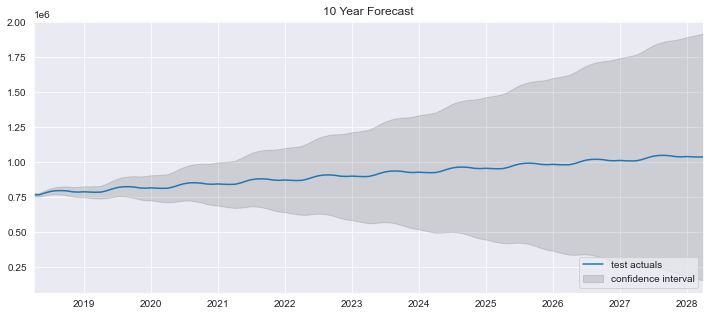

In [93]:
single_zip_analysis(final_df, 7627, display=True)